<a href="https://colab.research.google.com/github/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/StockPrediction_withNLP/GameStop(GME)Forecasting_LSTM_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip yfinance -q
!pip install torchmetrics -q
!pip install torchsummaryX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 8.9 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import seaborn as sns
import random
import numpy as np
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummaryX import summary
from tqdm.auto import tqdm
import os
import gc
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import datetime
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torchmetrics.regression import MeanAbsolutePercentageError

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


cuda:0


In [274]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from scipy.stats import spearmanr as spearman
def get_metrics(prediction, true_labels):
  metrics = ['MSE', 'RMSE','MAE', 'MAPE', 'Serial Corr', 'Pearson Corr(IC),', 'Spearman Corr(IC)']
  metrics_value = [
  MSE(prediction,true_labels),
  MSE(prediction,true_labels)**0.5,
  MAE(prediction,true_labels),
  MAPE(prediction,true_labels),
  np.corrcoef(prediction,true_labels)[0,1],
  np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1],
  spearman(np.diff(prediction),np.diff(true_labels))[0],
  ]

  return pd.DataFrame([metrics_value], columns=metrics)


# **Load Reddit News**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]
df_reddit

<ipython-input-4-a632c92e08de>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]


date                                              title  score  \
0        2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀    1.0   
1        2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀    1.0   
2        2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...    1.0   
3        2021-01-05  You already know what we must do brothers and ...    1.0   
4        2021-01-06                          ICR conference (11th Jan)    1.0   
...             ...                                                ...    ...   
1033231  2021-12-31  Hedgies are relics of past generations- they h...    1.0   
1033232  2021-12-31                                    Snapchat on 🔥🔥🔥    1.0   
1033233  2021-12-31  MOASS has ruined me this year. But I will stil...    1.0   
1033234  2021-12-31                               Patterns for 2022???    1.0   
1033235  2021-12-31                                        When GWagon    1.0   

         num_comments  
0                 9.0  
1                 1.0  
2                 6.0  
3                 4.0  
4                10.0  
...               ...  
1033231           0.0  
1033232           0.0  
1033233           0.0  
1033234           0.0  
1033235           0.0  

[1033236 rows x 4 columns]

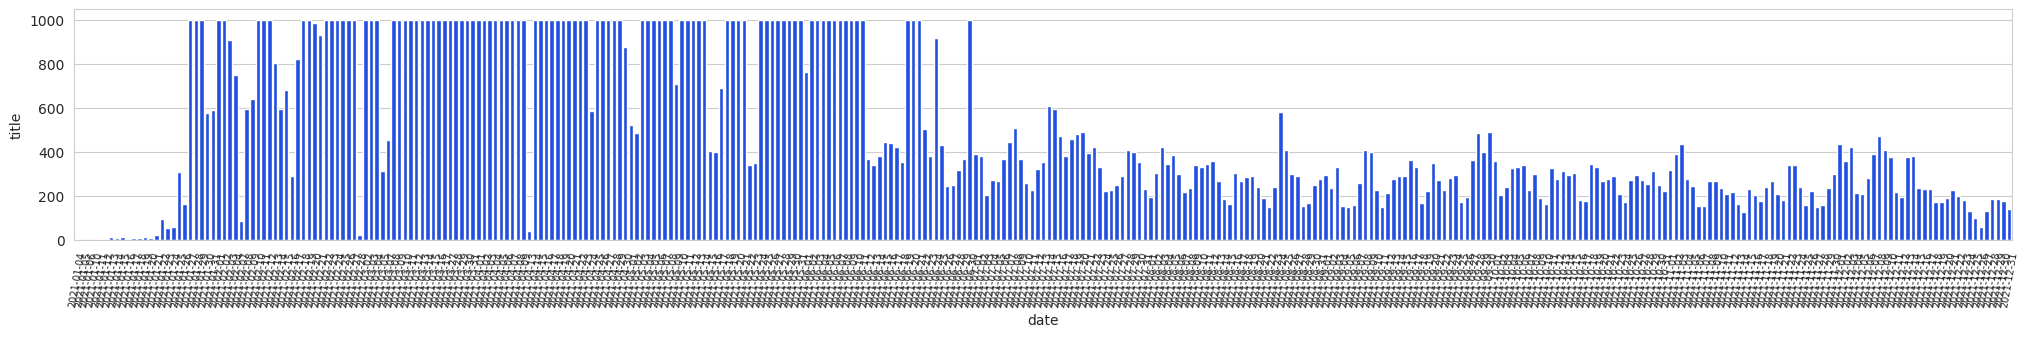

In [5]:
plt.figure(figsize=(25,3))
sns.set_style("whitegrid")
sns.set_palette("bright")
df_count = df_reddit.groupby('date').count().reset_index()
df_count['title']=df_count['title'].clip(0,1000)
sns.barplot(df_count, x='date', y='title')
plt.xticks(rotation=80, fontsize=7)
plt.show()

In [6]:
!pip install emoji -q
import emoji

def clean_text(text):
    import re
    text = emoji.demojize(text, delimiters=(" ", " "))  #emojis are important, keep them
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = cleaned_text.lower()
    return cleaned_text
df_reddit['title'] = df_reddit['title'].map(clean_text)
df_reddit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.8 MB/s eta 0:00:00


date                                              title  score  \
0        2021-01-04  you need to see this about gme  rocket  rocket...    1.0   
1        2021-01-04  short squeeze incoming  rocket  rocket  rocket...    1.0   
2        2021-01-05  this convinced me to all in  money_bag gme ext...    1.0   
3        2021-01-05  you already know what we must do brothers and ...    1.0   
4        2021-01-06                            icr conference 11th jan    1.0   
...             ...                                                ...    ...   
1033231  2021-12-31  hedgies are relics of past generations they ha...    1.0   
1033232  2021-12-31                     snapchat on  fire  fire  fire     1.0   
1033233  2021-12-31  moass has ruined me this year but i will still...    1.0   
1033234  2021-12-31                                  patterns for 2022    1.0   
1033235  2021-12-31                                        when gwagon    1.0   

         num_comments  
0                 9.0  
1                 1.0  
2                 6.0  
3                 4.0  
4                10.0  
...               ...  
1033231           0.0  
1033232           0.0  
1033233           0.0  
1033234           0.0  
1033235           0.0  

[1033236 rows x 4 columns]

## **Each day sample 300 news**

In [7]:
df_news = df_reddit.groupby('date').apply(lambda x: x.sample(min(len(x), 300))).reset_index(drop=True)
df_news

date                                              title  score  \
0      2021-01-04  short squeeze incoming  rocket  rocket  rocket...    1.0   
1      2021-01-04  you need to see this about gme  rocket  rocket...    1.0   
2      2021-01-05  this convinced me to all in  money_bag gme ext...    1.0   
3      2021-01-05  you already know what we must do brothers and ...    1.0   
4      2021-01-06  hey guys we have a free discord channel thats ...    1.0   
...           ...                                                ...    ...   
87686  2021-12-31  added another share of gme to make 2022 a very...    1.0   
87687  2021-12-31                                     tower of babel    1.0   
87688  2021-12-31             trip down memory lane i like the stock    1.0   
87689  2021-12-31  no i think gabe plotkin is one of the finest i...    1.0   
87690  2021-12-31         happy new year and a big f you to fidelity    1.0   

       num_comments  
0               1.0  
1               9.0  
2               6.0  
3               4.0  
4              15.0  
...             ...  
87686           0.0  
87687           0.0  
87688           0.0  
87689           0.0  
87690           0.0  

[87691 rows x 4 columns]

## **Load Time Series and Combine with News**

In [8]:
df = pd.read_csv('/content/drive/MyDrive/94812/prediction/s&p500_stocks.csv', index_col=[0], header=[0,1]).drop('Adj Close', level='Attribute', axis=1)
df.index = pd.to_datetime(df.index)
df = df.loc[:,('GME')].reset_index()
df

Attribute       Date     Open     High     Low    Close    Volume
0         2018-01-02   4.4900   4.5725   4.445   4.5650  11330800
1         2018-01-03   4.5725   4.5925   4.480   4.5500  15156800
2         2018-01-04   4.5500   4.5950   4.490   4.5800  11125200
3         2018-01-05   4.5950   4.6825   4.555   4.6700  12076000
4         2018-01-08   4.7000   4.8500   4.700   4.8075  14673600
...              ...      ...      ...     ...      ...       ...
1523      2024-01-23  15.0000  15.0200  14.050  14.1800   3495300
1524      2024-01-24  14.2800  14.3800  13.820  13.9500   2513800
1525      2024-01-25  13.9700  14.5400  13.920  14.5200   3635900
1526      2024-01-26  14.4400  14.7200  14.410  14.4900   2282300
1527      2024-01-29  14.5000  14.8100  14.320  14.7800   2164200

[1528 rows x 6 columns]

In [9]:
df_news['date'] = pd.to_datetime(df_news['date'])
df_gme_full=df_news.merge(df, how ='inner', left_on = 'date', right_on='Date').drop(columns=['date'])
df_gme_full

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4      hey guys we have a free discord channel thats ...    1.0          15.0   
...                                                  ...    ...           ...   
65056  added another share of gme to make 2022 a very...    1.0           0.0   
65057                                     tower of babel    1.0           0.0   
65058             trip down memory lane i like the stock    1.0           0.0   
65059  no i think gabe plotkin is one of the finest i...    1.0           0.0   
65060         happy new year and a big f you to fidelity    1.0           0.0   

            Date       Open       High        Low    Close    Volume  
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800  
...          ...        ...        ...        ...      ...       ...  
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  

[65061 rows x 9 columns]

## **How many News each day vs Stock Price**

<ipython-input-10-286f9bcee5fb>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)


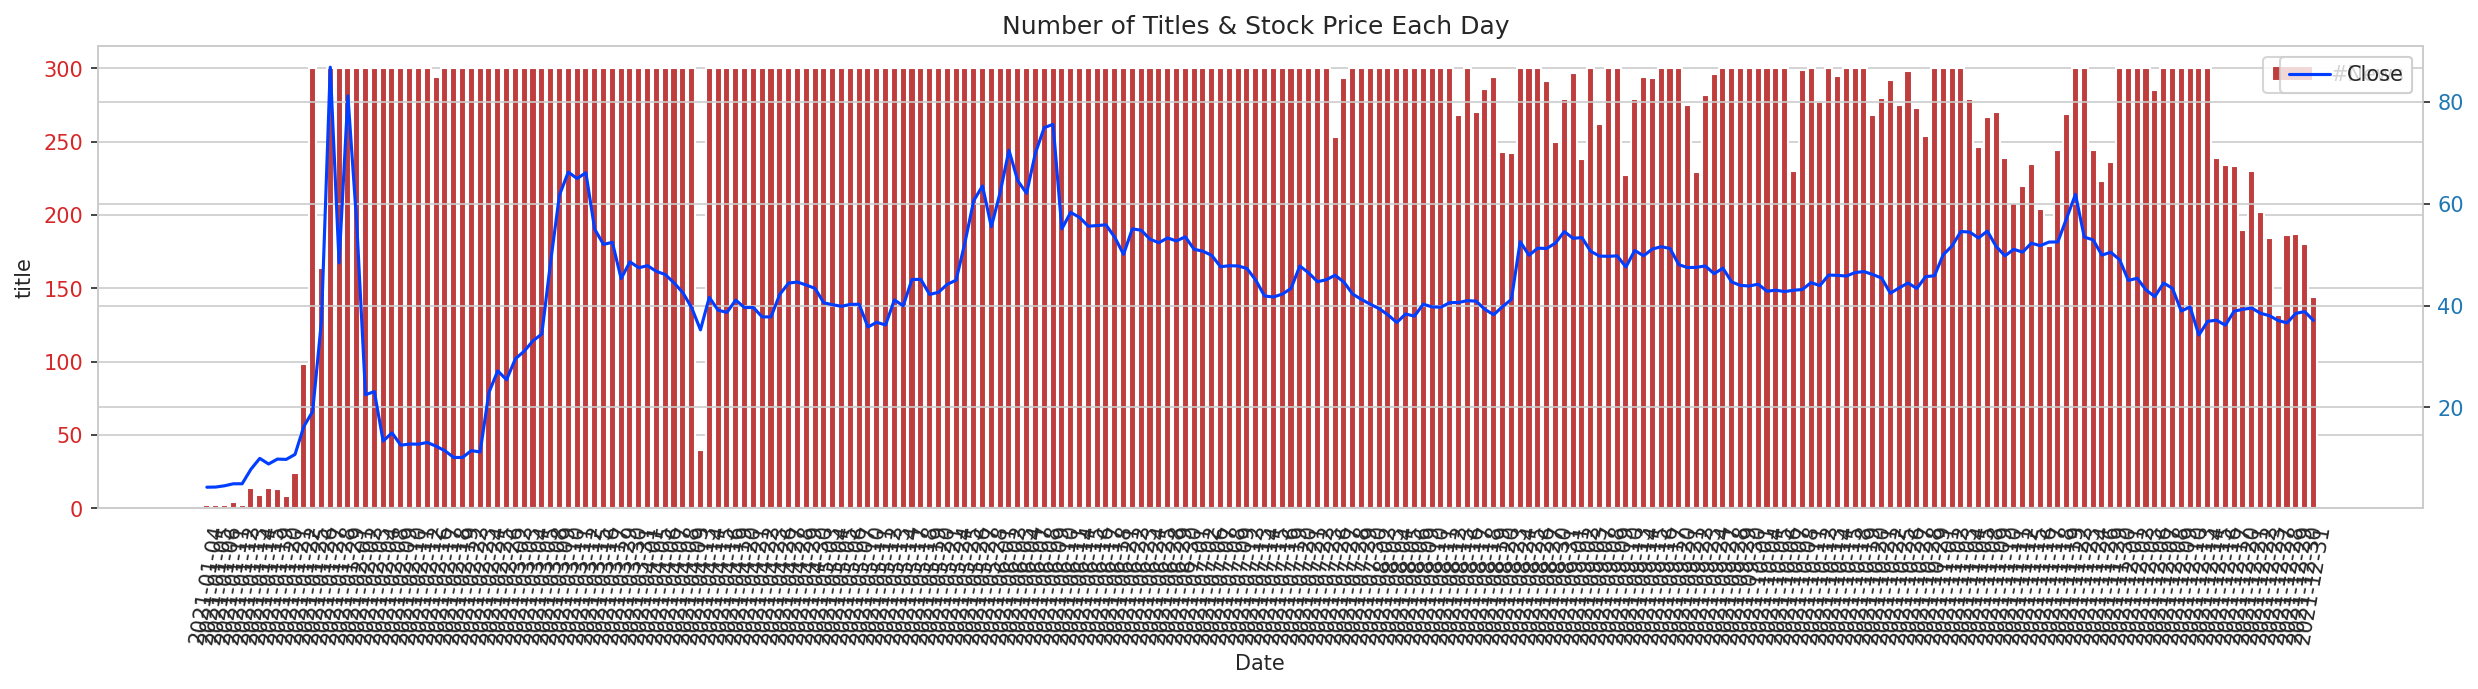

In [10]:
fig, ax1 = plt.subplots(figsize=(20, 4), dpi=150)
color = 'tab:red'
num_titles = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','title']].groupby('Date').count().reset_index()
# num_titles['Date'] = num_titles['Date'].apply(lambda x: str(x))
sns.barplot(num_titles, x='Date', y='title',color=color, ax=ax1, label="#News")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)

ax2 = ax1.twinx()
color = 'tab:blue'
price = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','Close']].groupby('Date').mean().reset_index()
# price['Date'] = price['Date'].apply(lambda x: str(x))
sns.lineplot(price, color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Number of Titles & Stock Price Each Day ")
plt.show()

In [11]:
df_gme_full.to_csv("2021_ts_news.csv")

## **Load Time Series & News Combined**

In [15]:
df = df_gme_full
# df = pd.read_csv('/content/drive/MyDrive/94812/prediction/2021_ts_news.csv').drop(columns=['Unnamed: 0','score','num_comments']).dropna()
df

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4      hey guys we have a free discord channel thats ...    1.0          15.0   
...                                                  ...    ...           ...   
65056  added another share of gme to make 2022 a very...    1.0           0.0   
65057                                     tower of babel    1.0           0.0   
65058             trip down memory lane i like the stock    1.0           0.0   
65059  no i think gabe plotkin is one of the finest i...    1.0           0.0   
65060         happy new year and a big f you to fidelity    1.0           0.0   

            Date       Open       High        Low    Close    Volume  
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800  
...          ...        ...        ...        ...      ...       ...  
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  

[65061 rows x 9 columns]

# **Explore Bert Sentiment Analysis**

## **Inference with Bert fine-tuned**

In [49]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

In [50]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [51]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [52]:
model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [53]:
gc.collect()
torch.cuda.empty_cache()

In [54]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index], self.token_type_ids[index], self.att_mask[index])

In [55]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 328,
    shuffle=False
)


In [56]:
# del X
gc.collect()
torch.cuda.empty_cache()

In [57]:
sentiments = []
for X in tqdm(inference_loader, "inferencing..."):

  res = model(X).cpu().detach().numpy()
  sentiments.append(res)
  del X
  gc.collect()
  torch.cuda.empty_cache()

df['sentiment'] = np.vstack(sentiments).argmax(1)
df

inferencing...:   0%|          | 0/199 [00:00<?, ?it/s]

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4      hey guys we have a free discord channel thats ...    1.0          15.0   
...                                                  ...    ...           ...   
65056  added another share of gme to make 2022 a very...    1.0           0.0   
65057                                     tower of babel    1.0           0.0   
65058             trip down memory lane i like the stock    1.0           0.0   
65059  no i think gabe plotkin is one of the finest i...    1.0           0.0   
65060         happy new year and a big f you to fidelity    1.0           0.0   

            Date       Open       High        Low    Close    Volume  \
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800   
...          ...        ...        ...        ...      ...       ...   
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   

       sentiment  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
65056          1  
65057          0  
65058          0  
65059          0  
65060          0  

[65061 rows x 10 columns]

In [58]:
df[['sentiment','Close']].groupby('sentiment').count()

Close
sentiment       
0          49436
1           1497
2          14128

In [59]:
df['sentiment'] = df['sentiment'].apply(lambda x: -1 if x==2 else x)
df

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4      hey guys we have a free discord channel thats ...    1.0          15.0   
...                                                  ...    ...           ...   
65056  added another share of gme to make 2022 a very...    1.0           0.0   
65057                                     tower of babel    1.0           0.0   
65058             trip down memory lane i like the stock    1.0           0.0   
65059  no i think gabe plotkin is one of the finest i...    1.0           0.0   
65060         happy new year and a big f you to fidelity    1.0           0.0   

            Date       Open       High        Low    Close    Volume  \
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800   
...          ...        ...        ...        ...      ...       ...   
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   

       sentiment  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
65056          1  
65057          0  
65058          0  
65059          0  
65060          0  

[65061 rows x 10 columns]

In [60]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)
dff['sentiment_change'] = dff['sentiment'].diff().fillna(0)
dff

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score  sentiment  price_change  sentiment_change  
Date                                                                           
2021-01-04      5.000000  1.000000   0.000000      0.000000          0.000000  
2021-01-05      5.000000  1.000000   0.000000      0.030000          0.000000  
2021-01-06     12.500000  1.000000   0.000000      0.247500          0.000000  
2021-01-11      9.500000  1.250000  -0.250000      0.395000         -0.250000  
2021-01-12     12.000000  1.500000  -0.500000      0.002500         -0.250000  
...                  ...       ...        ...           ...               ...  
2021-12-27      0.007576  1.007576  -0.098485     -0.957500         -0.049572  
2021-12-28      0.010753  1.005376  -0.155914     -0.462498         -0.057429  
2021-12-29      0.010695  1.000000  -0.192513      1.867496         -0.036599  
2021-12-30      0.005556  1.022222  -0.105556      0.350002          0.086958  
2021-12-31      0.013889  1.013889  -0.131944     -1.735001         -0.026389  

[240 rows x 10 columns]

## **Correlation between Sentiment & Price**

<Axes: xlabel='Date', ylabel='price_change'>

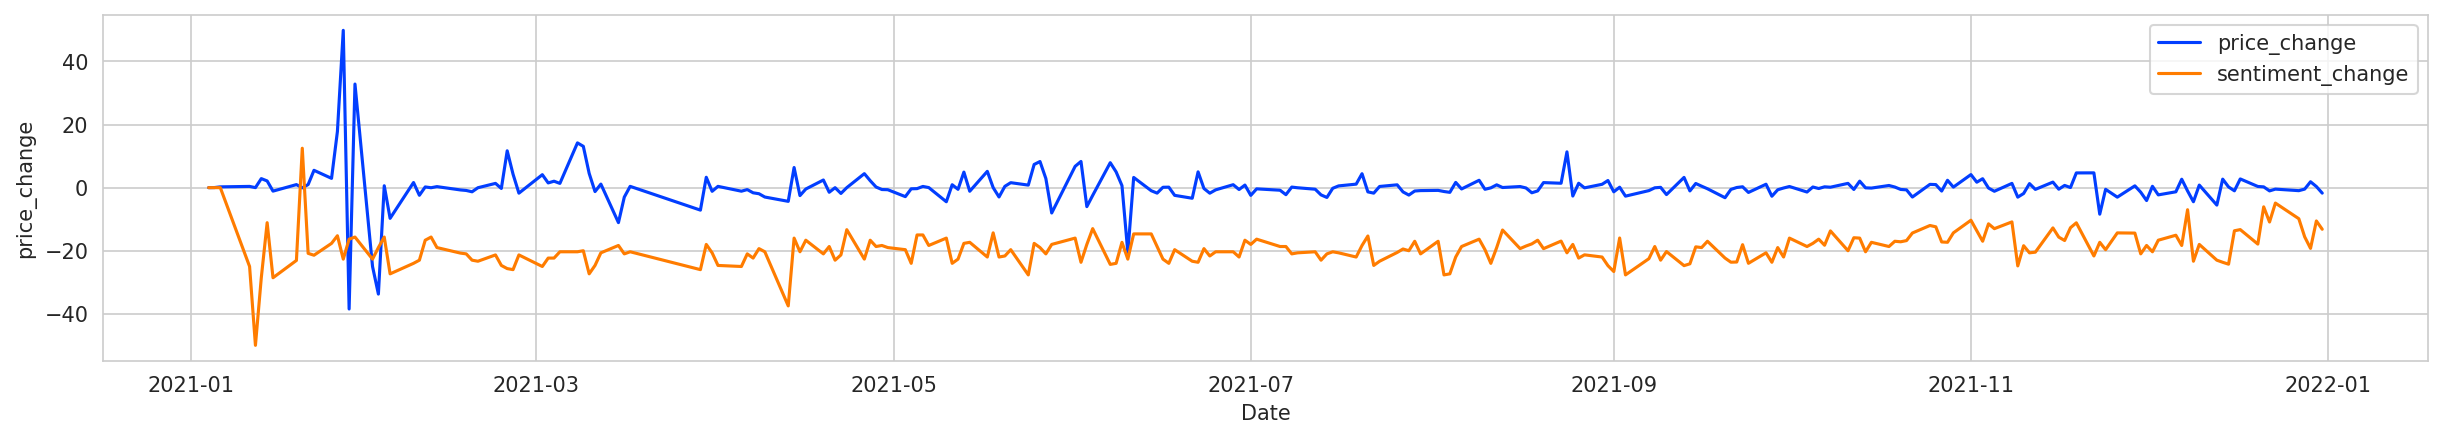

In [61]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment']*100, label = 'sentiment_change')


<Axes: xlabel='Date', ylabel='price_change'>

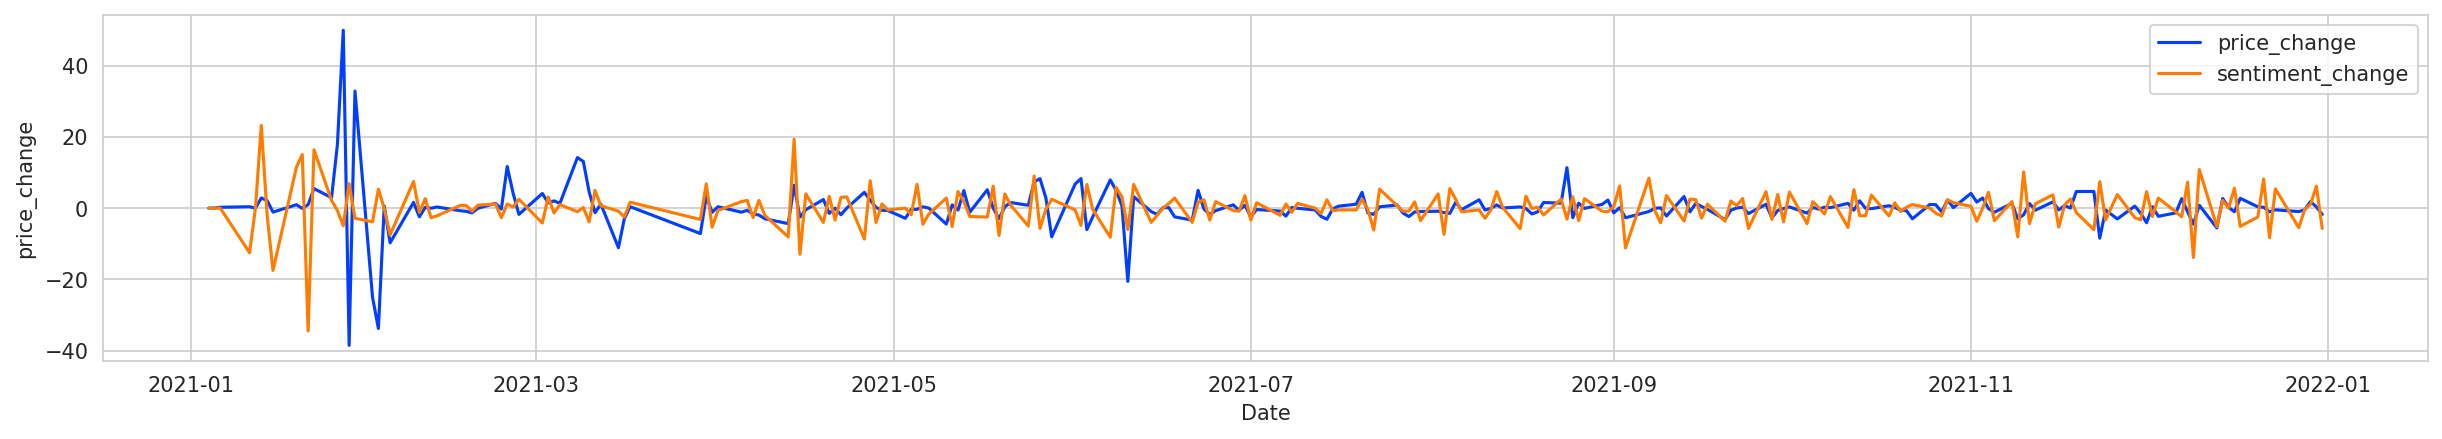

In [66]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment_change'].diff().fillna(0)*50, label = 'sentiment_change')


<Axes: >

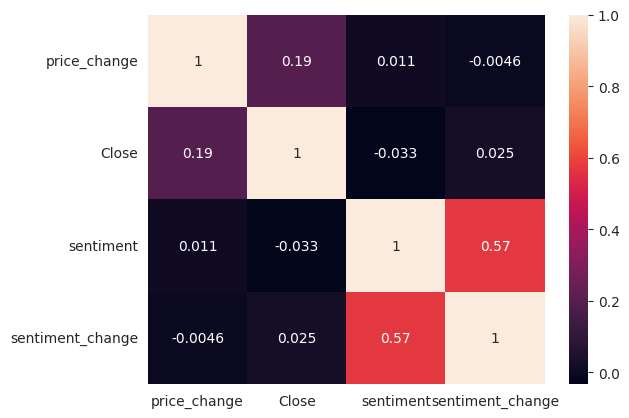

In [64]:
sns.heatmap(dff[['price_change','Close', 'sentiment','sentiment_change']].corr(),annot=True)

**The sentiment analysis our fine-tuned Bert gives does not give a good correlation with price or price change. Therefore we cannot use it to train LSTM. This can be due to several reasons: \
1.Our Bert is fine tuned on kaggle financial news headlines, which is drastically different from our Reddit post, and the model fails to generalize to Reddit post. \
2.Our model mostly outputs sentiment as neutral, if we could have included only positive and negative classes, or simply using the embeddings, it would give us stronger correlation with the stock price.\
But it serves as a good baseline methods, we'll train LSTM with sentiment labels first, and then explore Tf-idf embeddings, finally explore bert embeddings.**


# **Train with Baseline: with sentiment labels**

In [320]:
df_ts = df_full[['Close', 'High', 'Low', 'Open', 'Volume','sentiment']]
df_ts['Date']= df_full.index
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts.drop(columns=['Date'])

<ipython-input-320-f8d8b293ea87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date']= df_full.index
<ipython-input-320-f8d8b293ea87>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date'] = pd.to_datetime(df_ts['Date'])


### **Train Test Split**

In [321]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [322]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'sentiment'], dtype='object')


((70, 6), (20, 6), (65, 6))

In [323]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [324]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([32, 5]) torch.Size([32, 5, 6])
x:  tensor([-0.5001, -0.4696, -0.9618, -0.8796, -1.0022])
y_train:  tensor([-0.4696, -0.9618, -0.8796, -1.0022, -0.9909])


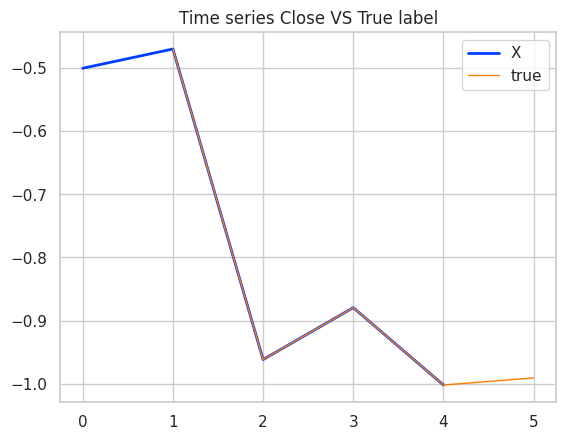

In [325]:
config = {
  'batch_size': 32,
  'lr':1e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [326]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [327]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([0.7265, 0.6955, 0.6128, 0.5153, 0.3648], device='cuda:0') tensor([0.6955, 0.6128, 0.5153, 0.3648, 0.1450], device='cuda:0')
x shape: torch.Size([32, 5, 6]) y shape: torch.Size([32, 5])
out shape: torch.Size([32, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [32, 5, 512]   1.06496M  1.060864M
1_model.0.Dropout_dp            -  [32, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [32, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [32, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [32, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [32, 5, 512]          -          -
6_model.Dropout_4               -  [32, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [32, 5, 1]      513.0      512.0
---------------------------------------------------------------------
   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [328]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [329]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [330]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9169	 Learning Rate 0.0010000	 Validation Loss 0.4826

Epoch: 2/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8069	 Learning Rate 0.0008000	 Validation Loss 0.3131

Epoch: 3/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.6980	 Learning Rate 0.0006400	 Validation Loss 0.1790

Epoch: 4/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5807	 Learning Rate 0.0005120	 Validation Loss 0.1677

Epoch: 5/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5365	 Learning Rate 0.0004096	 Validation Loss 0.1865

Epoch: 6/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4981	 Learning Rate 0.0003277	 Validation Loss 0.1997

Epoch: 7/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4535	 Learning Rate 0.0002621	 Validation Loss 0.2123

Epoch: 8/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4185	 Learning Rate 0.0002097	 Validation Loss 0.2105

Epoch: 9/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4105	 Learning Rate 0.0001678	 Validation Loss 0.2073

Epoch: 10/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4039	 Learning Rate 0.0001342	 Validation Loss 0.2027

Epoch: 11/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3837	 Learning Rate 0.0001074	 Validation Loss 0.1980

Epoch: 12/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3997	 Learning Rate 0.0000859	 Validation Loss 0.1938

Epoch: 13/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3910	 Learning Rate 0.0000687	 Validation Loss 0.1903

Epoch: 14/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3563	 Learning Rate 0.0000550	 Validation Loss 0.1875

Epoch: 15/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3804	 Learning Rate 0.0000440	 Validation Loss 0.1851

Epoch: 16/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3518	 Learning Rate 0.0000352	 Validation Loss 0.1836

Epoch: 17/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3379	 Learning Rate 0.0000281	 Validation Loss 0.1824

Epoch: 18/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3666	 Learning Rate 0.0000225	 Validation Loss 0.1811

Epoch: 19/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3708	 Learning Rate 0.0000180	 Validation Loss 0.1802

Epoch: 20/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3525	 Learning Rate 0.0000144	 Validation Loss 0.1796

Epoch: 21/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3479	 Learning Rate 0.0000115	 Validation Loss 0.1793

Epoch: 22/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3537	 Learning Rate 0.0000092	 Validation Loss 0.1789

Epoch: 23/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3454	 Learning Rate 0.0000074	 Validation Loss 0.1787

Epoch: 24/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3429	 Learning Rate 0.0000059	 Validation Loss 0.1784

Epoch: 25/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3643	 Learning Rate 0.0000047	 Validation Loss 0.1782

Epoch: 26/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3677	 Learning Rate 0.0000038	 Validation Loss 0.1781

Epoch: 27/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3582	 Learning Rate 0.0000030	 Validation Loss 0.1780

Epoch: 28/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3503	 Learning Rate 0.0000024	 Validation Loss 0.1779

Epoch: 29/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3453	 Learning Rate 0.0000019	 Validation Loss 0.1778

Epoch: 30/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3432	 Learning Rate 0.0000015	 Validation Loss 0.1778

Epoch: 31/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3480	 Learning Rate 0.0000012	 Validation Loss 0.1778

Epoch: 32/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3502	 Learning Rate 0.0000010	 Validation Loss 0.1777

Epoch: 33/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3460	 Learning Rate 0.0000008	 Validation Loss 0.1777

Epoch: 34/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3620	 Learning Rate 0.0000006	 Validation Loss 0.1777

Epoch: 35/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3657	 Learning Rate 0.0000005	 Validation Loss 0.1776

Epoch: 36/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3480	 Learning Rate 0.0000004	 Validation Loss 0.1776

Epoch: 37/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3581	 Learning Rate 0.0000003	 Validation Loss 0.1776

Epoch: 38/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3577	 Learning Rate 0.0000003	 Validation Loss 0.1776

Epoch: 39/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3706	 Learning Rate 0.0000002	 Validation Loss 0.1776

Epoch: 40/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3774	 Learning Rate 0.0000002	 Validation Loss 0.1776

Epoch: 41/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3524	 Learning Rate 0.0000001	 Validation Loss 0.1776

Epoch: 42/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3516	 Learning Rate 0.0000001	 Validation Loss 0.1776

Epoch: 43/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3358	 Learning Rate 0.0000001	 Validation Loss 0.1776

Epoch: 44/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3422	 Learning Rate 0.0000001	 Validation Loss 0.1776

Epoch: 45/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3505	 Learning Rate 0.0000001	 Validation Loss 0.1776

Epoch: 46/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3563	 Learning Rate 0.0000000	 Validation Loss 0.1776

Epoch: 47/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3547	 Learning Rate 0.0000000	 Validation Loss 0.1776

Epoch: 48/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3610	 Learning Rate 0.0000000	 Validation Loss 0.1776

Epoch: 49/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3476	 Learning Rate 0.0000000	 Validation Loss 0.1776

Epoch: 50/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3440	 Learning Rate 0.0000000	 Validation Loss 0.1776


Text(0.5, 1.0, 'Validation loss')

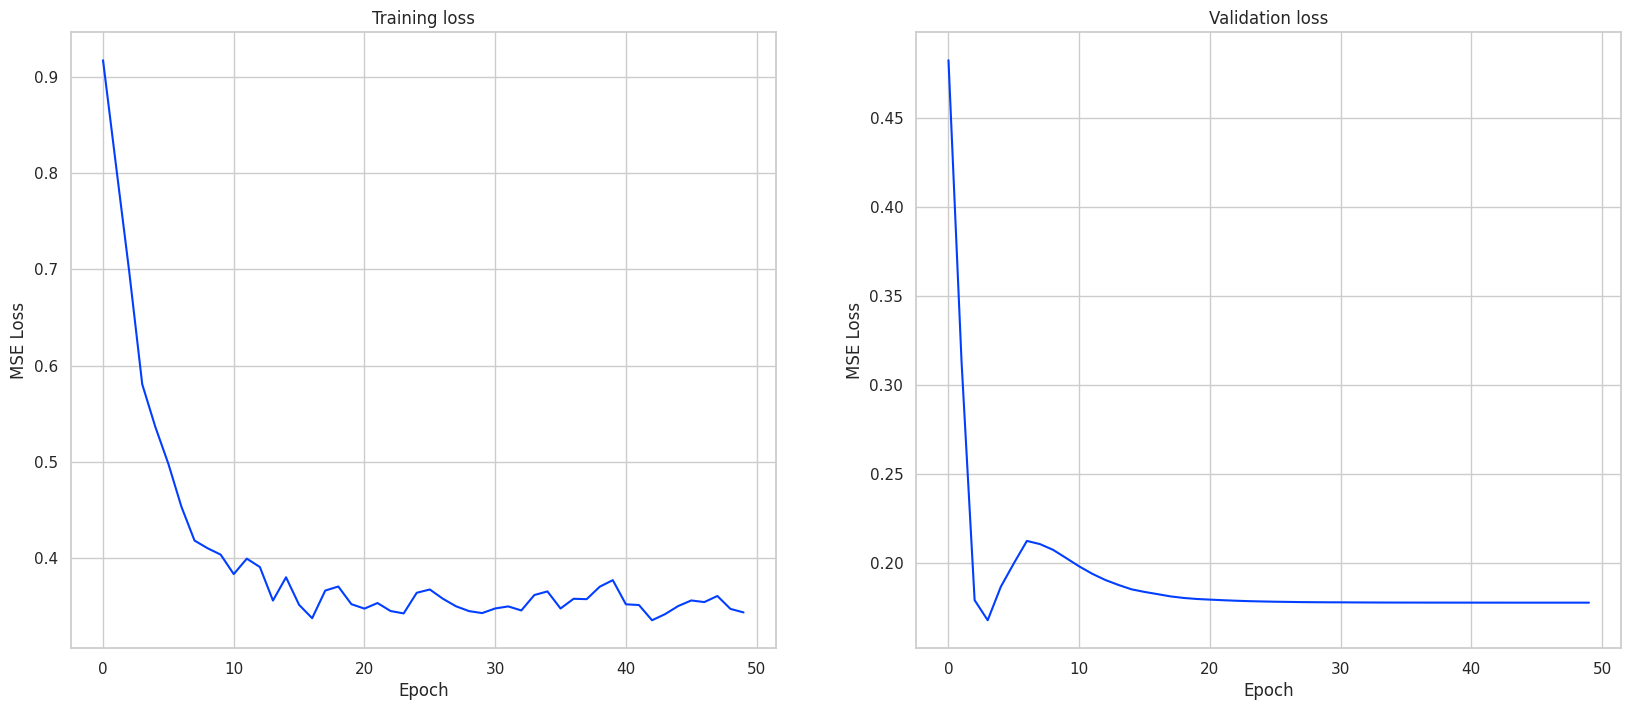

In [331]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [332]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
baseline_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE     RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  61.365913  7.83364  5.555622  0.125522     0.869164          -0.202205   

   Spearman Corr(IC)  
0          -0.096867

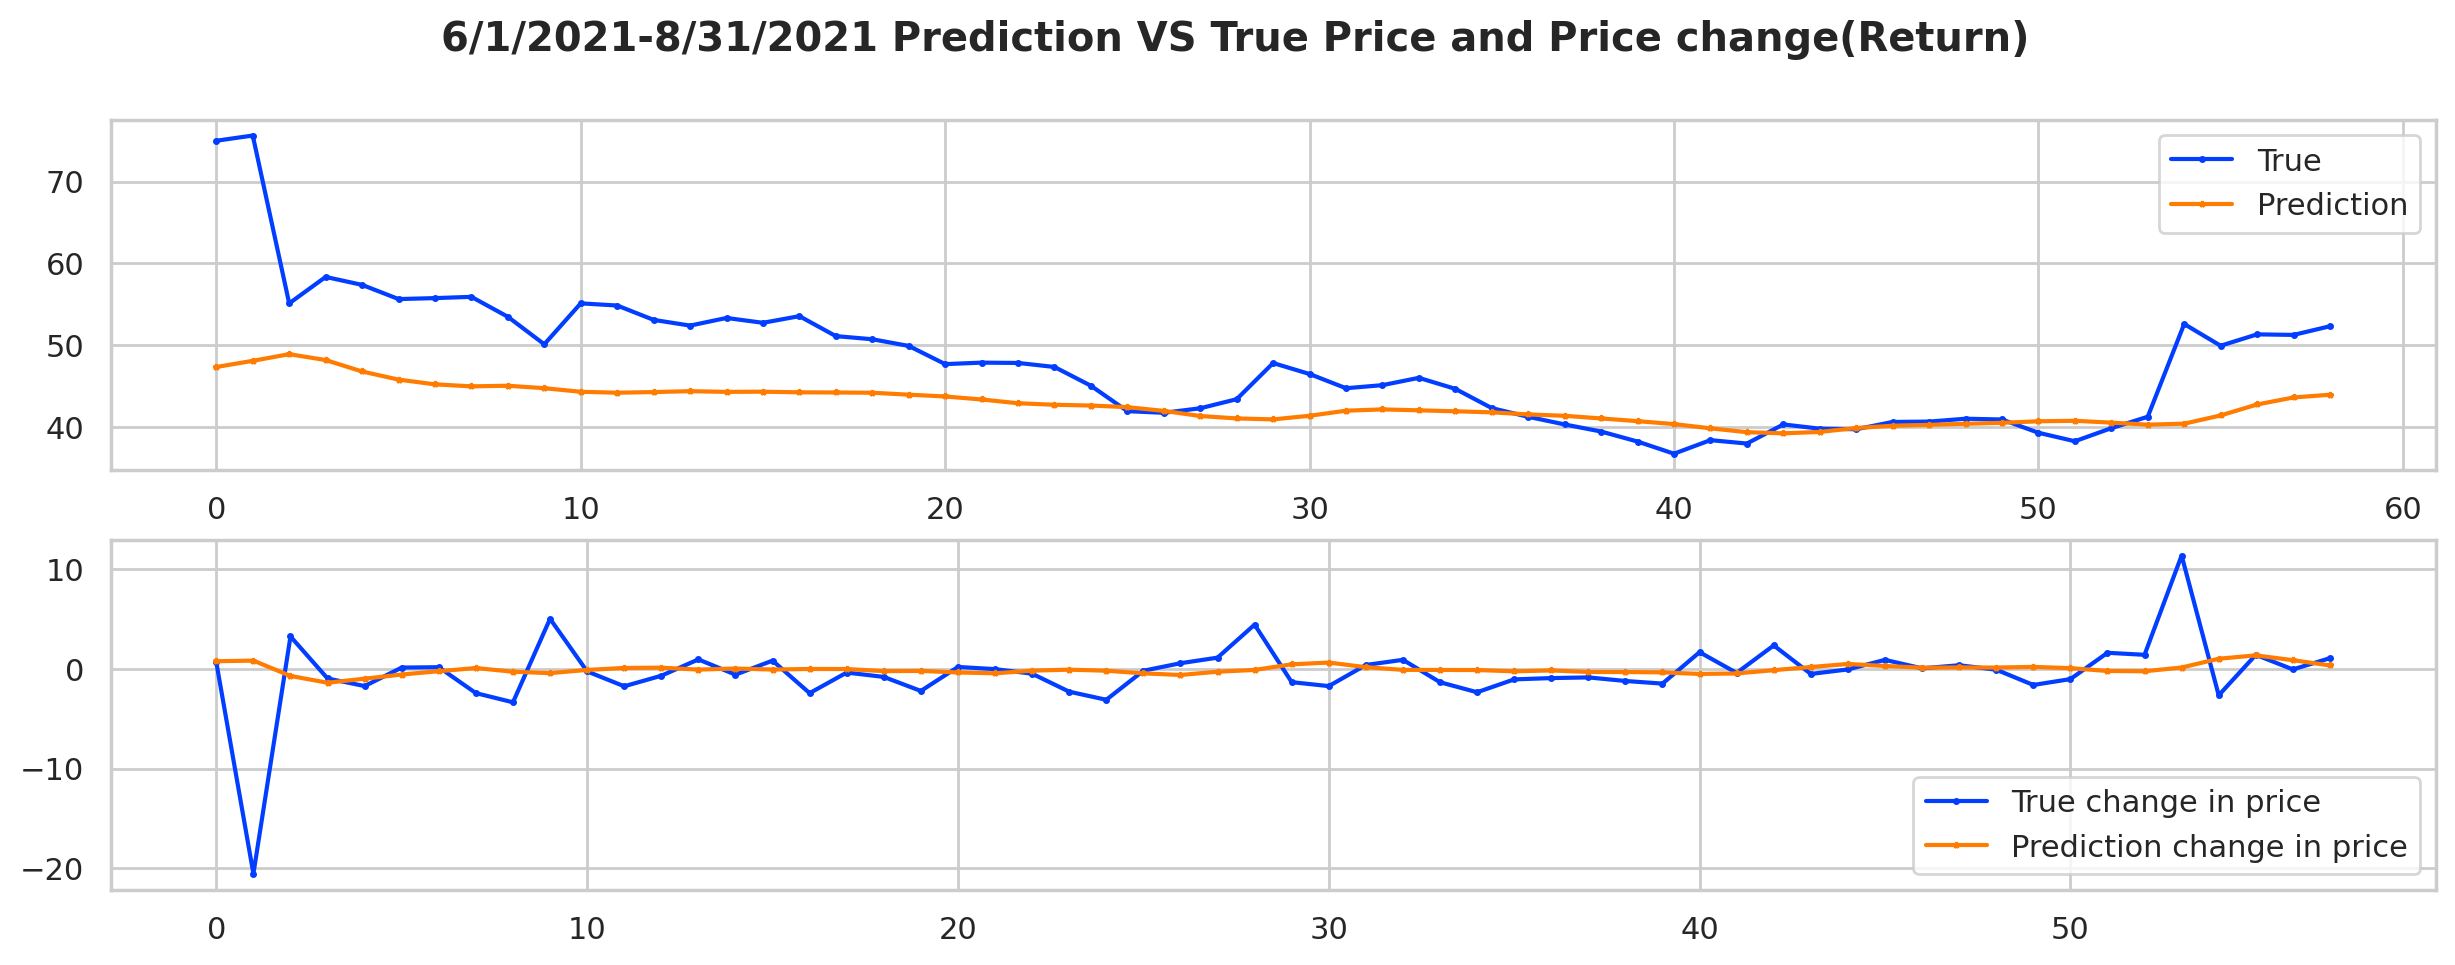

In [333]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)

ax[0].plot(true_labels, label='True', marker='.', markersize=3)
ax[0].plot(prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [334]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [335]:
prediction,true_labels=test(inference_loader)
# prediction = prediction[:,0]
# true_labels=true_labels[:,0]
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_train_test_metrics = get_metrics(prediction,true_labels)
baseline_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE       RMSE       MAE    MAPE  Serial Corr  Pearson Corr(IC),  \
0  102.263992  10.112566  6.775729  0.1899     0.808284           0.198938   

   Spearman Corr(IC)  
0           0.106855

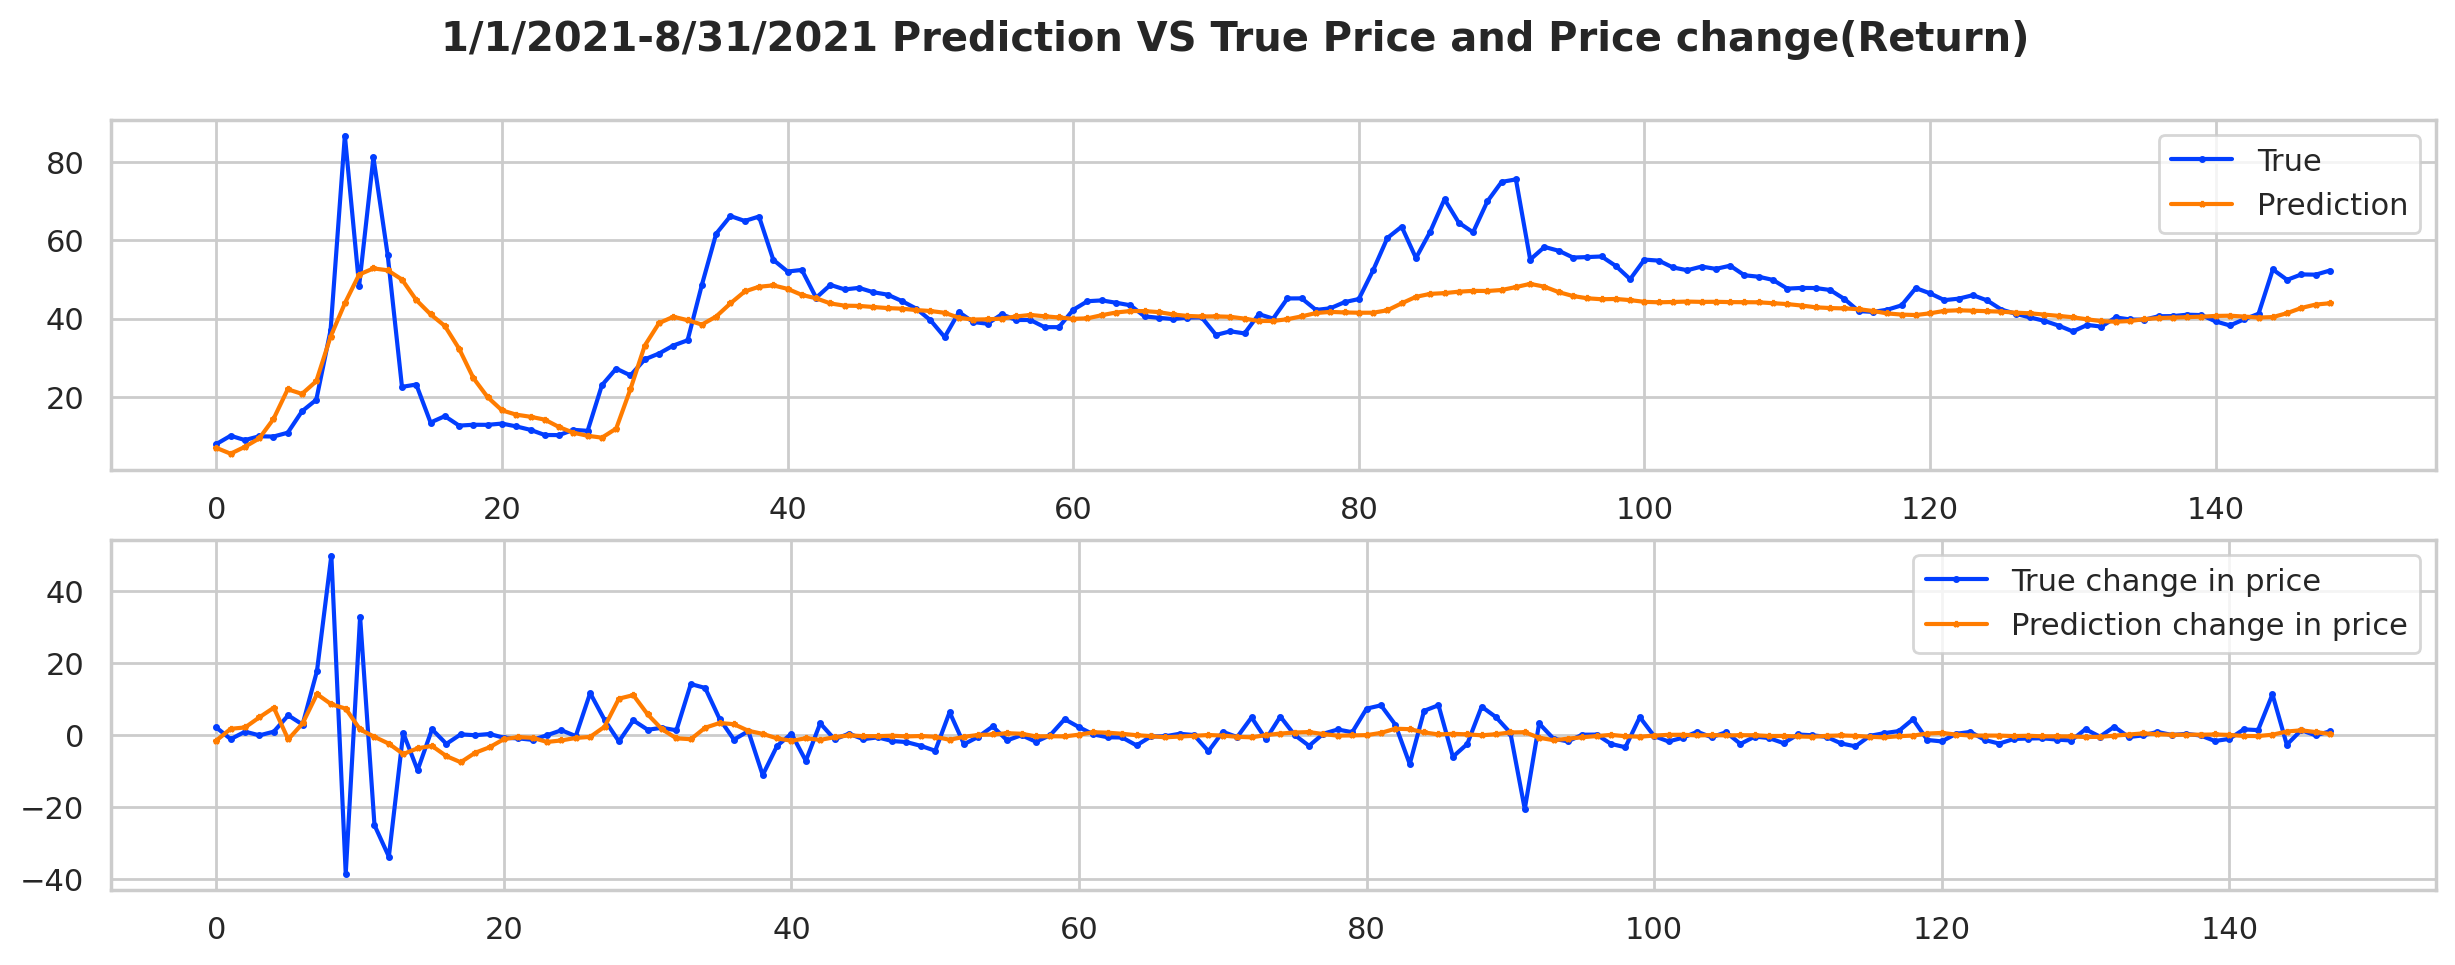

In [336]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)

ax[0].plot(true_labels, label='True', marker='.', markersize=3)
ax[0].plot(prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore TF-IDF**

In [67]:
#combine Reddit titles each day to calculate TF-IDF, each day, we only take the first 10k words
df_comb_titles = df[['title','Date']].groupby('Date')['title'].apply('. '.join)
df_comb_titles  = pd.DataFrame(df_comb_titles)
df_comb_titles['title'] = df_comb_titles['title'].apply(lambda x:x[:10000])
df_comb_titles

title
Date                                                         
2021-01-04  short squeeze incoming  rocket  rocket  rocket...
2021-01-05  this convinced me to all in  money_bag gme ext...
2021-01-06  hey guys we have a free discord channel thats ...
2021-01-11  ryan cohen appointed to board. holly fck our g...
2021-01-12  low volume the day after cohen essentially tak...
...                                                       ...
2021-12-27  what is first song you will play after moass f...
2021-12-28  dont know what i was dragging my feet over the...
2021-12-29  next year be like. the narrative it changing t...
2021-12-30  today fudelity questioned why im drsing my sha...
2021-12-31  beep boop  germany . longest erection i have e...

[240 rows x 1 columns]

In [68]:
df_comb_titles['title'].apply(lambda x:len(x)).describe()

count      240.000000
mean      9492.133333
std       2084.785844
min        109.000000
25%      10000.000000
50%      10000.000000
75%      10000.000000
max      10000.000000
Name: title, dtype: float64

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b')
tfidf_matrix = vectorizer.fit_transform(list(df_comb_titles['title']))
print("TF-IDF shape: ",tfidf_matrix.shape)

dense_matrix = tfidf_matrix.todense()
df_tfidf = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_tfidf

TF-IDF shape:  (240, 19015)


a   aa  aaa  aaaaaaaahhhhhhhh  aaaaaaaand  aaaaaaaannnnddd  \
0    0.000000  0.0  0.0               0.0         0.0              0.0   
1    0.089885  0.0  0.0               0.0         0.0              0.0   
2    0.093839  0.0  0.0               0.0         0.0              0.0   
3    0.000000  0.0  0.0               0.0         0.0              0.0   
4    0.101130  0.0  0.0               0.0         0.0              0.0   
..        ...  ...  ...               ...         ...              ...   
235  0.146260  0.0  0.0               0.0         0.0              0.0   
236  0.139325  0.0  0.0               0.0         0.0              0.0   
237  0.121023  0.0  0.0               0.0         0.0              0.0   
238  0.129246  0.0  0.0               0.0         0.0              0.0   
239  0.167820  0.0  0.0               0.0         0.0              0.0   

     aaaaaand  aaaaand  aaaaannnnddd  aaaahhhh  ...  zoom  zoomed  zoomer  \
0         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
1         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
2         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
3         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
4         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
..        ...      ...           ...       ...  ...   ...     ...     ...   
235       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
236       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
237       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
238       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
239       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   

     zooming  zooms  zoooooommmmm  zora   zu  zwebsites  zzz  
0        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
1        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
2        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
3        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
4        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
..       ...    ...           ...   ...  ...        ...  ...  
235      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
236      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
237      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
238      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
239      0.0    0.0           0.0   0.0  0.0        0.0  0.0  

[240 rows x 19015 columns]

In [218]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)

## **PCA from 19k+dims to 200 dims**

In [219]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(np.array(dense_matrix))

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio.sum())

# If you want to examine the PCA result as a DataFrame
df_pca = pd.DataFrame(pca_result,columns=['pc'+str(i) for i in range(n_comp)])
df_pca.index = dff.index
df_pca

Explained variance ratio: 0.9118513735588424


pc0       pc1       pc2       pc3       pc4       pc5  \
Date                                                                     
2021-01-04  0.695336  0.362871  0.520831 -0.260848  0.036988 -0.120549   
2021-01-05  0.230040  0.524534 -0.249523 -0.044887 -0.411033  0.223505   
2021-01-06  0.300935  0.615216 -0.291094 -0.024683 -0.165725  0.119229   
2021-01-11  0.395156  0.560876 -0.061609 -0.201462  0.312364  0.033342   
2021-01-12  0.175607  0.479112 -0.282987 -0.034508  0.620683  0.129681   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.089995  0.035942  0.083009 -0.072369  0.064876  0.023852   
2021-12-28 -0.139245  0.000133  0.039902 -0.001701  0.094045  0.062138   
2021-12-29 -0.202612  0.028980 -0.036773  0.044067  0.049613  0.071159   
2021-12-30 -0.094686  0.051935  0.001255 -0.054912 -0.010952  0.025760   
2021-12-31 -0.101868  0.005948 -0.050260  0.003021  0.064085  0.076400   

                 pc6       pc7       pc8       pc9  ...     pc190     pc191  \
Date                                                ...                       
2021-01-04  0.033589  0.029867  0.015924  0.029306  ... -0.008728 -0.006905   
2021-01-05 -0.126000  0.093247 -0.222695  0.489722  ...  0.000203 -0.003698   
2021-01-06 -0.231194  0.520185  0.598568 -0.142925  ...  0.000668  0.000606   
2021-01-11 -0.174900  0.110515 -0.412759  0.078957  ... -0.004247  0.001752   
2021-01-12 -0.136043 -0.032813 -0.033650 -0.061807  ... -0.001712  0.001596   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.100708  0.018648 -0.042205 -0.040006  ...  0.042141 -0.024354   
2021-12-28  0.075078  0.015614  0.000633 -0.002434  ...  0.057289 -0.044059   
2021-12-29  0.036422  0.015424 -0.016473  0.001772  ... -0.042805 -0.026979   
2021-12-30  0.059282  0.041835 -0.038481  0.011779  ... -0.009634  0.015407   
2021-12-31  0.110436  0.020881  0.008143 -0.036491  ...  0.042646  0.008773   

               pc192     pc193     pc194     pc195     pc196     pc197  \
Date                                                                     
2021-01-04  0.000515  0.006061 -0.008507  0.014520 -0.017879 -0.003122   
2021-01-05  0.000100 -0.001420  0.000971 -0.007247  0.001605 -0.002428   
2021-01-06 -0.001746  0.001770 -0.003556  0.000347  0.005947  0.000217   
2021-01-11 -0.004930  0.003195 -0.000238 -0.007289 -0.006430  0.010487   
2021-01-12  0.005813  0.001766 -0.000381  0.001268  0.017099 -0.007202   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.029719  0.070767 -0.020627 -0.002264  0.021549 -0.021847   
2021-12-28  0.001005 -0.031333 -0.034954  0.074349 -0.036473  0.052657   
2021-12-29  0.009190  0.023205 -0.012620 -0.050255 -0.070530 -0.056237   
2021-12-30 -0.007293  0.021044 -0.006879 -0.033819  0.006828 -0.017176   
2021-12-31  0.017755 -0.018126  0.021152  0.007998  0.016350  0.007927   

               pc198     pc199  
Date                            
2021-01-04 -0.026911  0.004043  
2021-01-05 -0.009237 -0.008763  
2021-01-06  0.004015  0.005845  
2021-01-11  0.000498  0.004523  
2021-01-12  0.013243  0.003104  
...              ...       ...  
2021-12-27  0.017343 -0.005358  
2021-12-28 -0.018260  0.013614  
2021-12-29  0.004109  0.019561  
2021-12-30 -0.022916  0.011872  
2021-12-31  0.004056  0.020907  

[240 rows x 200 columns]

In [220]:
df_full = pd.concat([dff,df_pca],axis=1)
df_full

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score  sentiment  price_change       pc0  ...  \
Date                                                                   ...   
2021-01-04      5.000000  1.000000   0.000000      0.000000  0.695336  ...   
2021-01-05      5.000000  1.000000   0.000000      0.030000  0.230040  ...   
2021-01-06     12.500000  1.000000   0.000000      0.247500  0.300935  ...   
2021-01-11      9.500000  1.250000  -0.250000      0.395000  0.395156  ...   
2021-01-12     12.000000  1.500000  -0.500000      0.002500  0.175607  ...   
...                  ...       ...        ...           ...       ...  ...   
2021-12-27      0.007576  1.007576  -0.098485     -0.957500 -0.089995  ...   
2021-12-28      0.010753  1.005376  -0.155914     -0.462498 -0.139245  ...   
2021-12-29      0.010695  1.000000  -0.192513      1.867496 -0.202612  ...   
2021-12-30      0.005556  1.022222  -0.105556      0.350002 -0.094686  ...   
2021-12-31      0.013889  1.013889  -0.131944     -1.735001 -0.101868  ...   

               pc190     pc191     pc192     pc193     pc194     pc195  \
Date                                                                     
2021-01-04 -0.008728 -0.006905  0.000515  0.006061 -0.008507  0.014520   
2021-01-05  0.000203 -0.003698  0.000100 -0.001420  0.000971 -0.007247   
2021-01-06  0.000668  0.000606 -0.001746  0.001770 -0.003556  0.000347   
2021-01-11 -0.004247  0.001752 -0.004930  0.003195 -0.000238 -0.007289   
2021-01-12 -0.001712  0.001596  0.005813  0.001766 -0.000381  0.001268   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.042141 -0.024354  0.029719  0.070767 -0.020627 -0.002264   
2021-12-28  0.057289 -0.044059  0.001005 -0.031333 -0.034954  0.074349   
2021-12-29 -0.042805 -0.026979  0.009190  0.023205 -0.012620 -0.050255   
2021-12-30 -0.009634  0.015407 -0.007293  0.021044 -0.006879 -0.033819   
2021-12-31  0.042646  0.008773  0.017755 -0.018126  0.021152  0.007998   

               pc196     pc197     pc198     pc199  
Date                                                
2021-01-04 -0.017879 -0.003122 -0.026911  0.004043  
2021-01-05  0.001605 -0.002428 -0.009237 -0.008763  
2021-01-06  0.005947  0.000217  0.004015  0.005845  
2021-01-11 -0.006430  0.010487  0.000498  0.004523  
2021-01-12  0.017099 -0.007202  0.013243  0.003104  
...              ...       ...       ...       ...  
2021-12-27  0.021549 -0.021847  0.017343 -0.005358  
2021-12-28 -0.036473  0.052657 -0.018260  0.013614  
2021-12-29 -0.070530 -0.056237  0.004109  0.019561  
2021-12-30  0.006828 -0.017176 -0.022916  0.011872  
2021-12-31  0.016350  0.007927  0.004056  0.020907  

[240 rows x 209 columns]

## **Correlation between TF-IDF(PCA) & Price**

<Axes: >

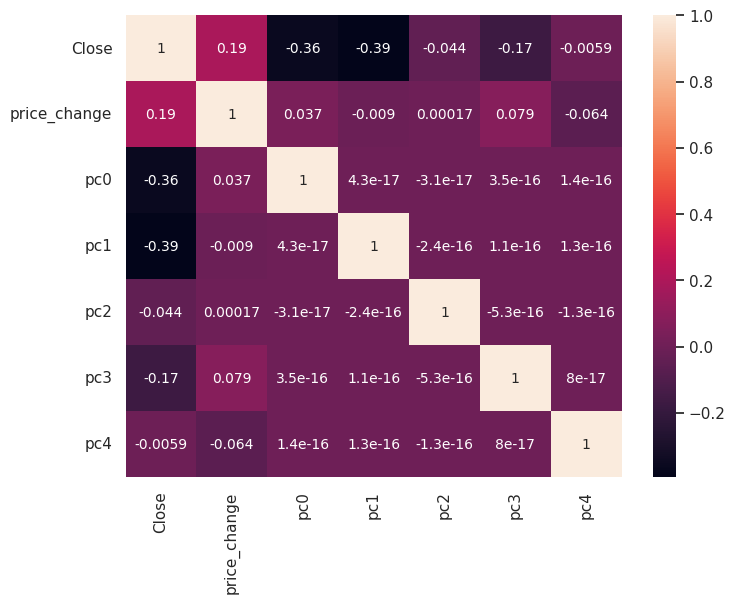

In [221]:
plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(df_full[['Close','price_change','pc0','pc1','pc2','pc3','pc4']].corr(),annot=True,annot_kws={"size":10})

Text(0.5, 1.0, 'GameStop(GME) stock price VS Principal Component')

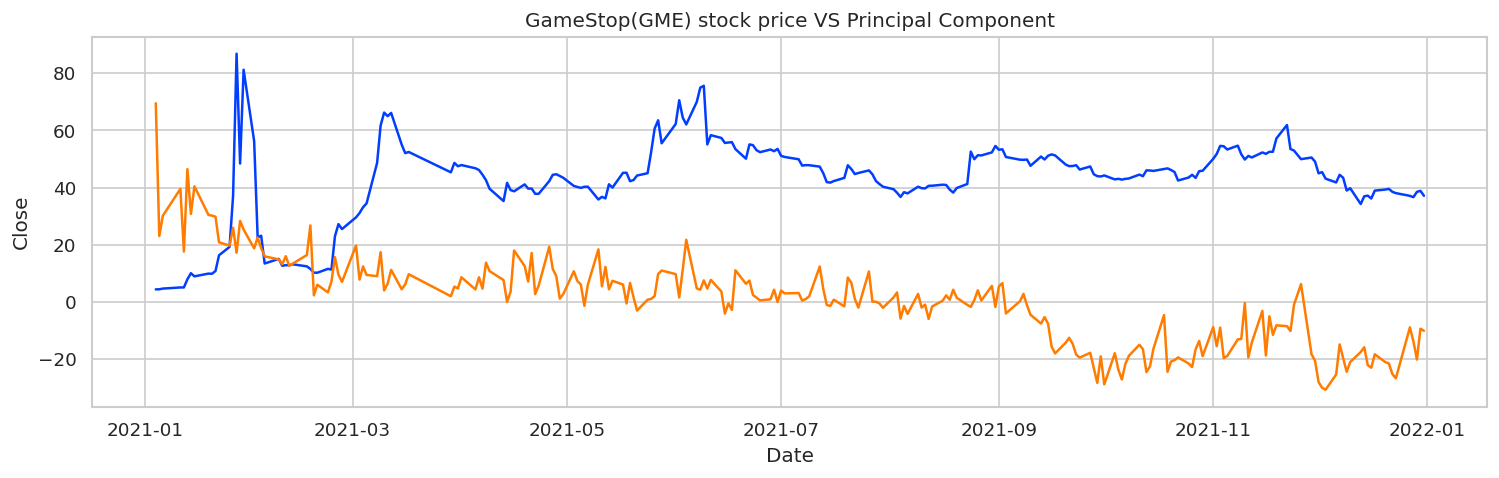

In [222]:
plt.figure(figsize=(15,4),dpi=120)
sns.set(style="whitegrid", palette="bright")
sns.lineplot(df_full['Close'])
sns.lineplot(df_full['pc0']*100)
plt.title("GameStop(GME) stock price VS Principal Component")

## **Time Series with TF-IDF features**

In [223]:
df_ts=df_full.copy().reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts.drop(columns=['Date','score','price_change','num_comments','sentiment'])
df_ts #dimension should be 5(open, high, low, close, volume) +200 =205

Close       High        Low       Open      Volume       pc0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0  0.695336   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0  0.230040   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0  0.300935   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0  0.395156   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0  0.175607   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.089995   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.139245   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.202612   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.094686   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.101868   

                 pc1       pc2       pc3       pc4  ...     pc190     pc191  \
Date                                                ...                       
2021-01-04  0.362871  0.520831 -0.260848  0.036988  ... -0.008728 -0.006905   
2021-01-05  0.524534 -0.249523 -0.044887 -0.411033  ...  0.000203 -0.003698   
2021-01-06  0.615216 -0.291094 -0.024683 -0.165725  ...  0.000668  0.000606   
2021-01-11  0.560876 -0.061609 -0.201462  0.312364  ... -0.004247  0.001752   
2021-01-12  0.479112 -0.282987 -0.034508  0.620683  ... -0.001712  0.001596   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.035942  0.083009 -0.072369  0.064876  ...  0.042141 -0.024354   
2021-12-28  0.000133  0.039902 -0.001701  0.094045  ...  0.057289 -0.044059   
2021-12-29  0.028980 -0.036773  0.044067  0.049613  ... -0.042805 -0.026979   
2021-12-30  0.051935  0.001255 -0.054912 -0.010952  ... -0.009634  0.015407   
2021-12-31  0.005948 -0.050260  0.003021  0.064085  ...  0.042646  0.008773   

               pc192     pc193     pc194     pc195     pc196     pc197  \
Date                                                                     
2021-01-04  0.000515  0.006061 -0.008507  0.014520 -0.017879 -0.003122   
2021-01-05  0.000100 -0.001420  0.000971 -0.007247  0.001605 -0.002428   
2021-01-06 -0.001746  0.001770 -0.003556  0.000347  0.005947  0.000217   
2021-01-11 -0.004930  0.003195 -0.000238 -0.007289 -0.006430  0.010487   
2021-01-12  0.005813  0.001766 -0.000381  0.001268  0.017099 -0.007202   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.029719  0.070767 -0.020627 -0.002264  0.021549 -0.021847   
2021-12-28  0.001005 -0.031333 -0.034954  0.074349 -0.036473  0.052657   
2021-12-29  0.009190  0.023205 -0.012620 -0.050255 -0.070530 -0.056237   
2021-12-30 -0.007293  0.021044 -0.006879 -0.033819  0.006828 -0.017176   
2021-12-31  0.017755 -0.018126  0.021152  0.007998  0.016350  0.007927   

               pc198     pc199  
Date                            
2021-01-04 -0.026911  0.004043  
2021-01-05 -0.009237 -0.008763  
2021-01-06  0.004015  0.005845  
2021-01-11  0.000498  0.004523  
2021-01-12  0.013243  0.003104  
...              ...       ...  
2021-12-27  0.017343 -0.005358  
2021-12-28 -0.018260  0.013614  
2021-12-29  0.004109  0.019561  
2021-12-30 -0.022916  0.011872  
2021-12-31  0.004056  0.020907  

[240 rows x 205 columns]

# **Training with Tf-idf**

### **Train Test Split**

In [225]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [226]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'pc0', 'pc1', 'pc2', 'pc3',
       'pc4',
       ...
       'pc190', 'pc191', 'pc192', 'pc193', 'pc194', 'pc195', 'pc196', 'pc197',
       'pc198', 'pc199'],
      dtype='object', length=205)


((70, 205), (20, 205), (65, 205))

In [227]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [228]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([32, 5]) torch.Size([32, 5, 205])
x:  tensor([-1.1337, -1.1895, -1.1407, -1.1437, -1.0943])
y_train:  tensor([-1.1895, -1.1407, -1.1437, -1.0943, -0.8162])


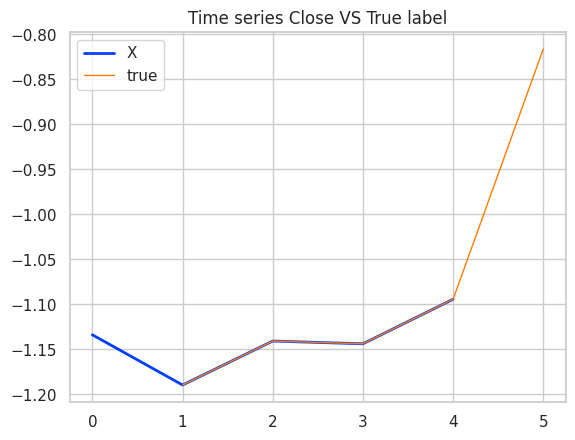

In [229]:
config = {
  'batch_size': 32,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [230]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)


In [231]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([1.4849, 1.7139, 1.6506, 1.7075, 1.1463], device='cuda:0') tensor([1.7139, 1.6506, 1.7075, 1.1463, 0.9949], device='cuda:0')
x shape: torch.Size([32, 5, 205]) y shape: torch.Size([32, 5])
out shape: torch.Size([32, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [32, 5, 512]  1.472512M  1.468416M
1_model.0.Dropout_dp            -  [32, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [32, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [32, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [32, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [32, 5, 512]          -          -
6_model.Dropout_4               -  [32, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [32, 5, 1]      513.0      512.0
---------------------------------------------------------------------
 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [232]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [233]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [234]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8971	 Learning Rate 0.0020000	 Validation Loss 0.4510

Epoch: 2/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3664	 Learning Rate 0.0016000	 Validation Loss 0.3131

Epoch: 3/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7145	 Learning Rate 0.0012800	 Validation Loss 0.5057

Epoch: 4/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1761	 Learning Rate 0.0010240	 Validation Loss 0.5726

Epoch: 5/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3733	 Learning Rate 0.0008192	 Validation Loss 0.5909

Epoch: 6/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3340	 Learning Rate 0.0006554	 Validation Loss 0.5869

Epoch: 7/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2555	 Learning Rate 0.0005243	 Validation Loss 0.5804

Epoch: 8/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1915	 Learning Rate 0.0004194	 Validation Loss 0.5752

Epoch: 9/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1275	 Learning Rate 0.0003355	 Validation Loss 0.5730

Epoch: 10/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1009	 Learning Rate 0.0002684	 Validation Loss 0.5692

Epoch: 11/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1094	 Learning Rate 0.0002147	 Validation Loss 0.5670

Epoch: 12/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1168	 Learning Rate 0.0001718	 Validation Loss 0.5633

Epoch: 13/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0785	 Learning Rate 0.0001374	 Validation Loss 0.5603

Epoch: 14/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0735	 Learning Rate 0.0001100	 Validation Loss 0.5565

Epoch: 15/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0678	 Learning Rate 0.0000880	 Validation Loss 0.5532

Epoch: 16/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0629	 Learning Rate 0.0000704	 Validation Loss 0.5510

Epoch: 17/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0747	 Learning Rate 0.0000563	 Validation Loss 0.5480

Epoch: 18/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0829	 Learning Rate 0.0000450	 Validation Loss 0.5459

Epoch: 19/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0693	 Learning Rate 0.0000360	 Validation Loss 0.5442

Epoch: 20/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0603	 Learning Rate 0.0000288	 Validation Loss 0.5429

Epoch: 21/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0513	 Learning Rate 0.0000231	 Validation Loss 0.5421

Epoch: 22/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0675	 Learning Rate 0.0000184	 Validation Loss 0.5416

Epoch: 23/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0605	 Learning Rate 0.0000148	 Validation Loss 0.5412

Epoch: 24/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0836	 Learning Rate 0.0000118	 Validation Loss 0.5409

Epoch: 25/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0745	 Learning Rate 0.0000094	 Validation Loss 0.5407

Epoch: 26/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0769	 Learning Rate 0.0000076	 Validation Loss 0.5406

Epoch: 27/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0510	 Learning Rate 0.0000060	 Validation Loss 0.5406

Epoch: 28/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0442	 Learning Rate 0.0000048	 Validation Loss 0.5406

Epoch: 29/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0663	 Learning Rate 0.0000039	 Validation Loss 0.5405

Epoch: 30/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0723	 Learning Rate 0.0000031	 Validation Loss 0.5405

Epoch: 31/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0592	 Learning Rate 0.0000025	 Validation Loss 0.5405

Epoch: 32/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0582	 Learning Rate 0.0000020	 Validation Loss 0.5405

Epoch: 33/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0461	 Learning Rate 0.0000016	 Validation Loss 0.5405

Epoch: 34/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0703	 Learning Rate 0.0000013	 Validation Loss 0.5405

Epoch: 35/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0631	 Learning Rate 0.0000010	 Validation Loss 0.5405

Epoch: 36/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0484	 Learning Rate 0.0000008	 Validation Loss 0.5405

Epoch: 37/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0478	 Learning Rate 0.0000006	 Validation Loss 0.5405

Epoch: 38/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0634	 Learning Rate 0.0000005	 Validation Loss 0.5405

Epoch: 39/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0916	 Learning Rate 0.0000004	 Validation Loss 0.5405

Epoch: 40/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0614	 Learning Rate 0.0000003	 Validation Loss 0.5405

Epoch: 41/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0551	 Learning Rate 0.0000003	 Validation Loss 0.5405

Epoch: 42/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0747	 Learning Rate 0.0000002	 Validation Loss 0.5405

Epoch: 43/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0539	 Learning Rate 0.0000002	 Validation Loss 0.5405

Epoch: 44/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0626	 Learning Rate 0.0000001	 Validation Loss 0.5405

Epoch: 45/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0637	 Learning Rate 0.0000001	 Validation Loss 0.5405

Epoch: 46/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0674	 Learning Rate 0.0000001	 Validation Loss 0.5405

Epoch: 47/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0670	 Learning Rate 0.0000001	 Validation Loss 0.5405

Epoch: 48/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0638	 Learning Rate 0.0000001	 Validation Loss 0.5405

Epoch: 49/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0754	 Learning Rate 0.0000000	 Validation Loss 0.5405

Epoch: 50/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0404	 Learning Rate 0.0000000	 Validation Loss 0.5405


Text(0.5, 1.0, 'Validation loss')

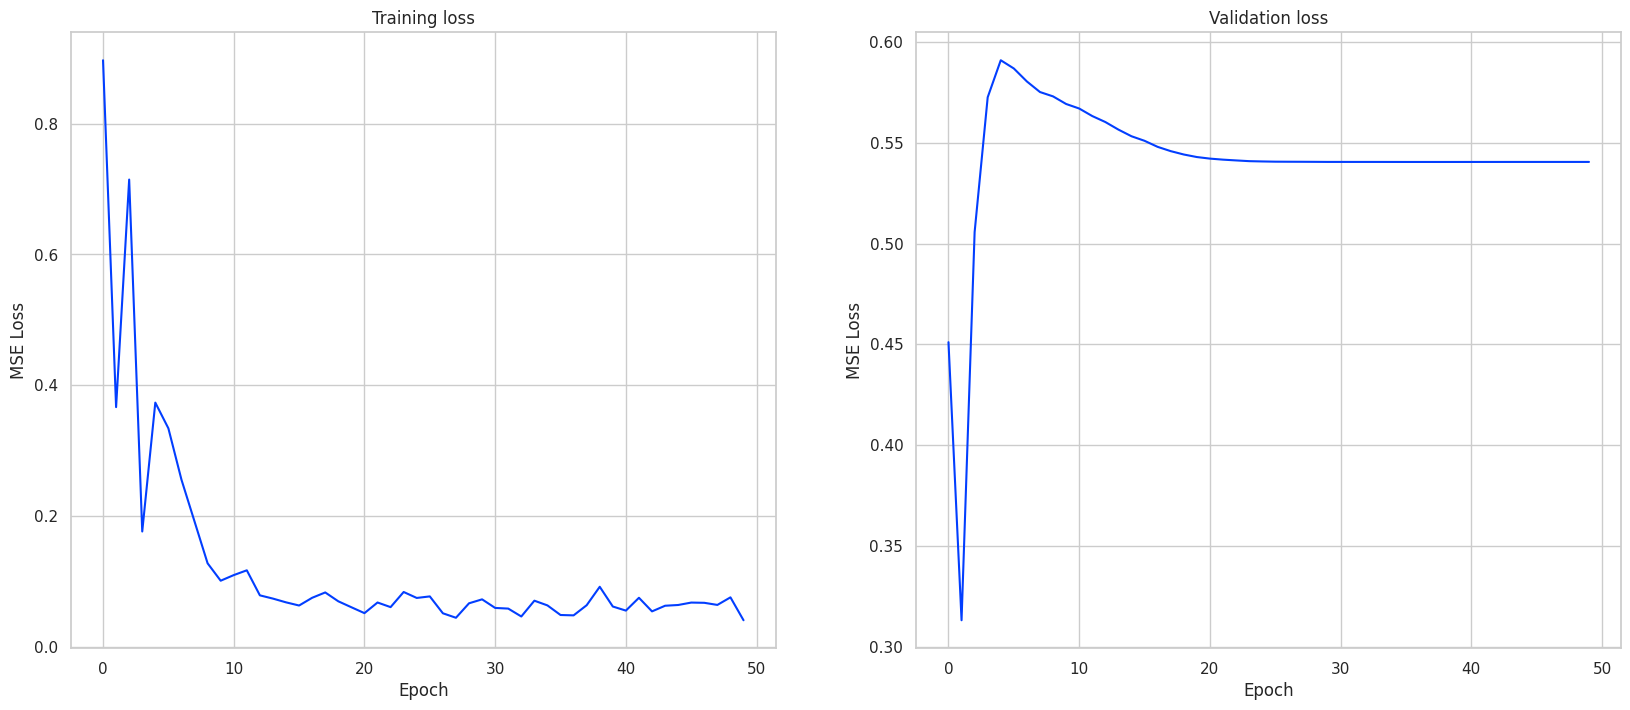

In [235]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [249]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_test_metrics=get_metrics(prediction,true_labels)
tfidf_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE       RMSE        MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  204.023376  14.283675  12.749937  0.365236      0.62122          -0.045079   

   Spearman Corr(IC)  
0           0.033622

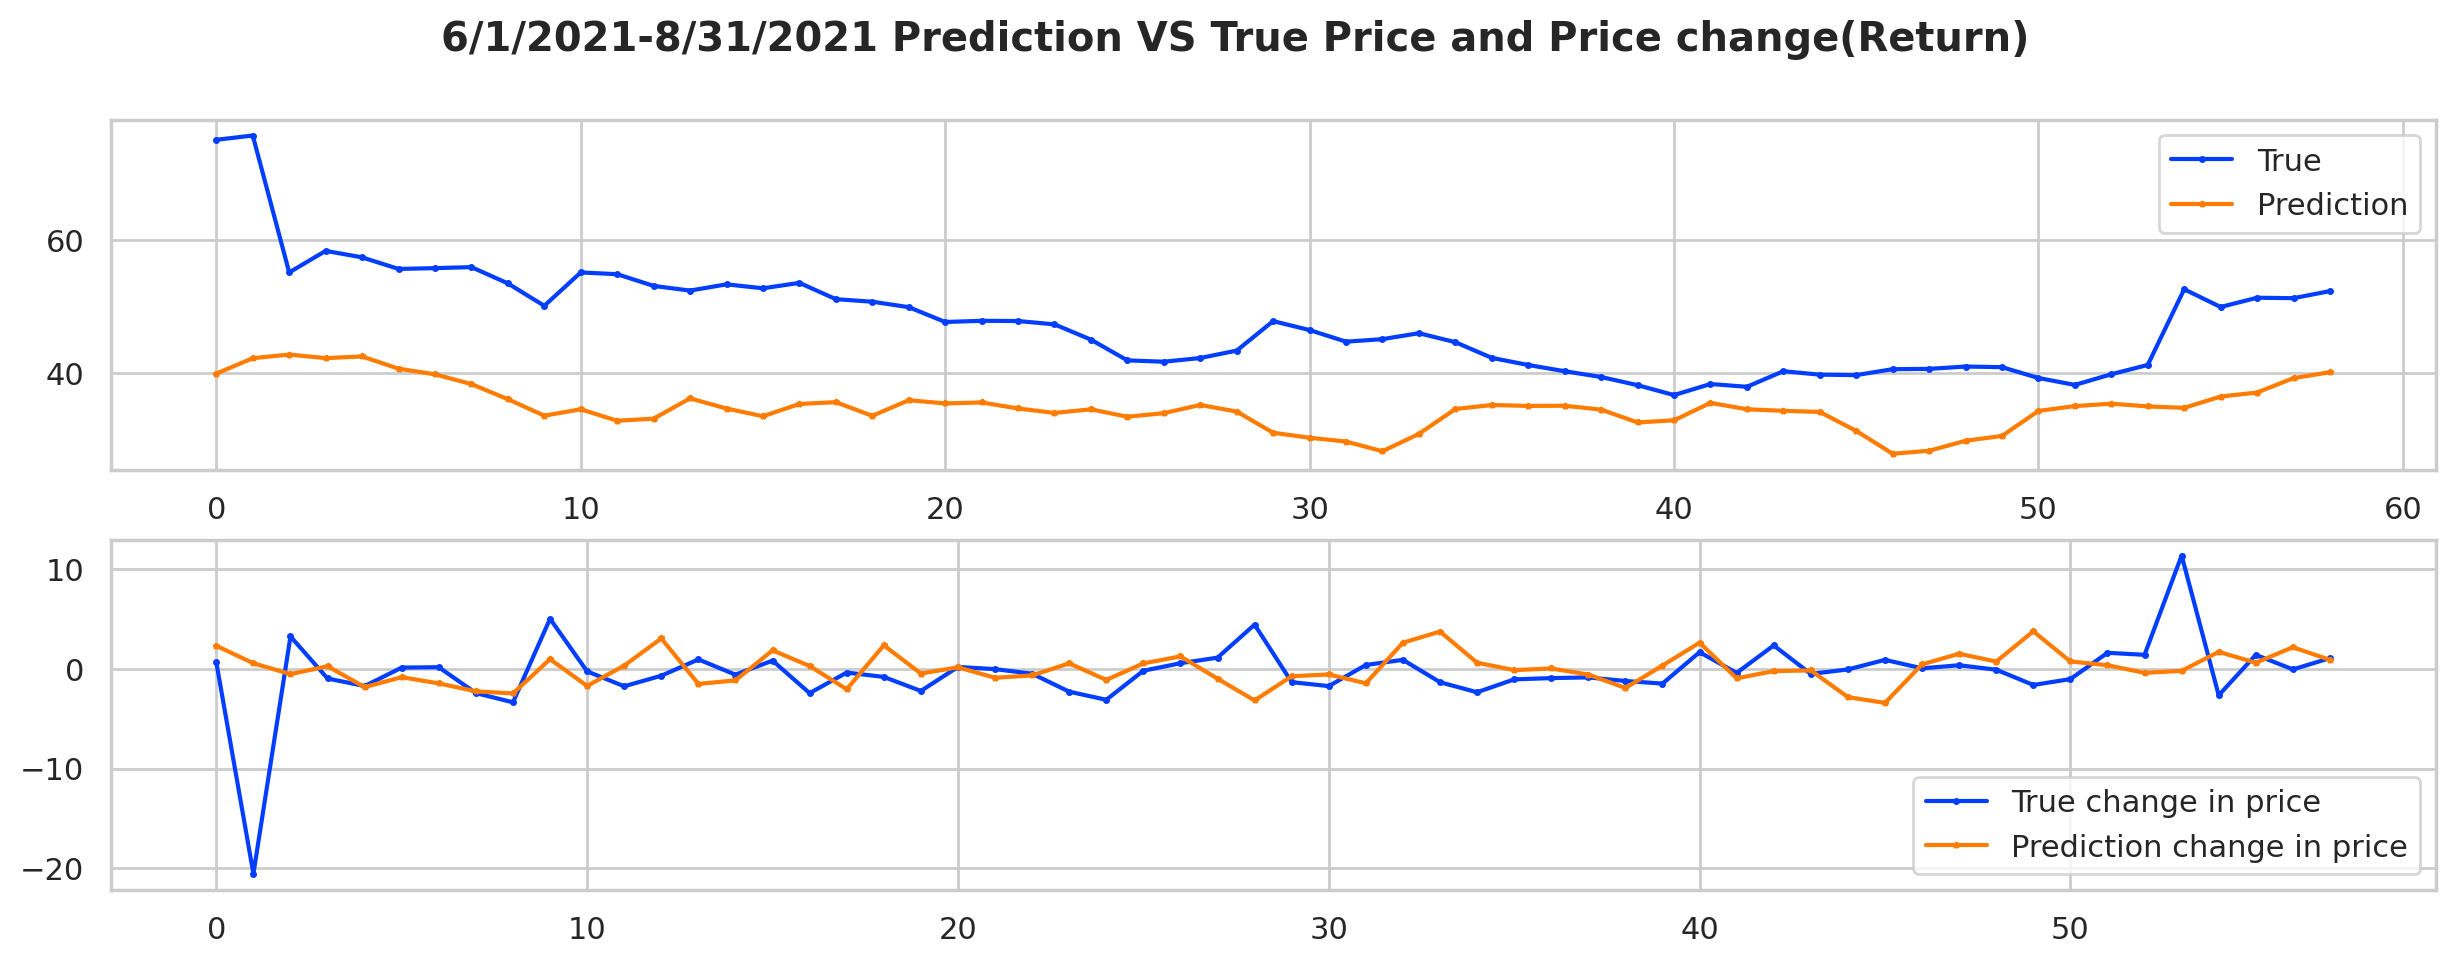

In [250]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)

ax[0].plot(true_labels, label='True', marker='.', markersize=3)
ax[0].plot(prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [251]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [252]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_train_test_metrics=get_metrics(prediction,true_labels)
tfidf_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE      RMSE      MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  146.304016  12.09562  8.59887  0.252513     0.801432           0.628973   

   Spearman Corr(IC)  
0           0.351494

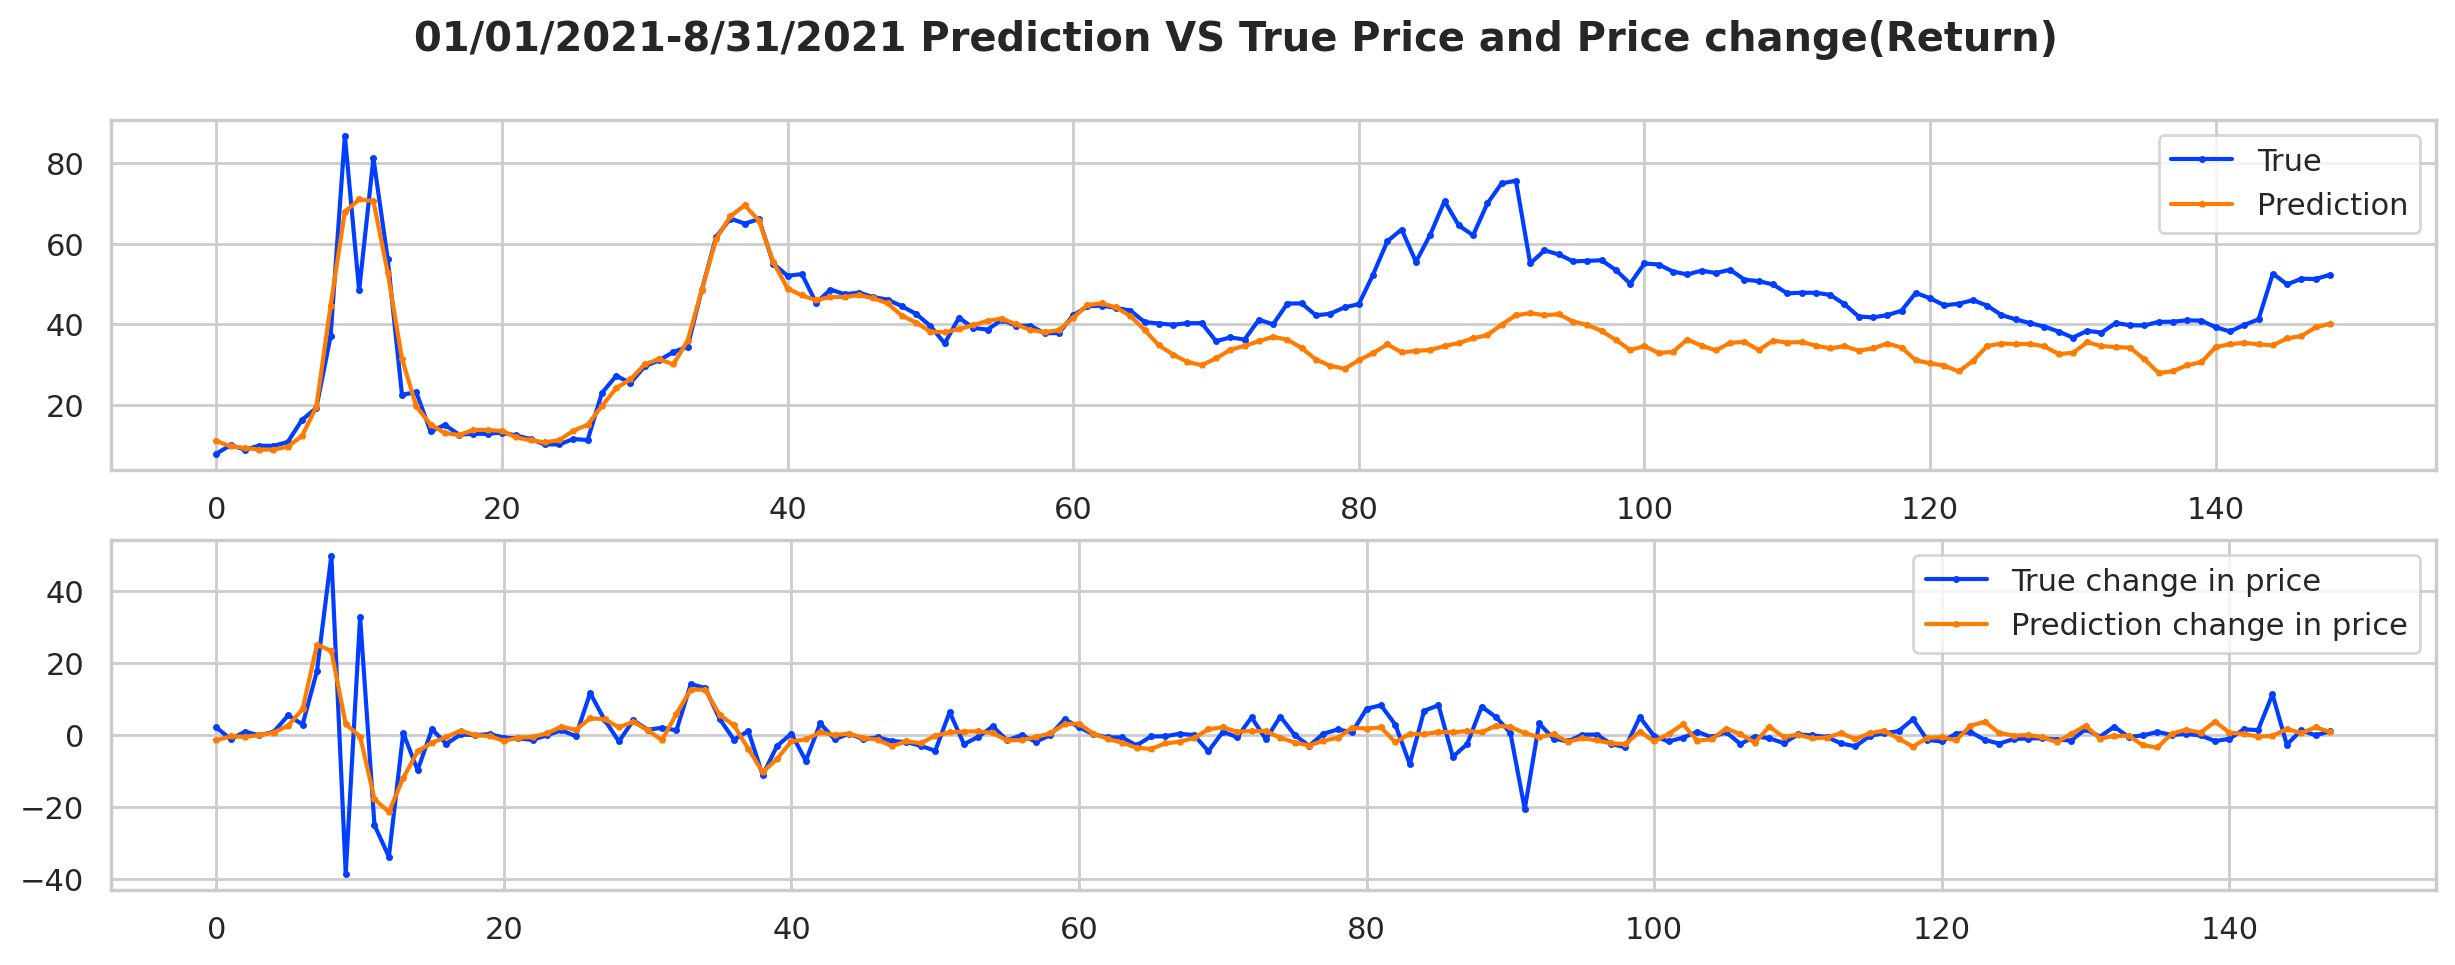

In [253]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)

ax[0].plot(true_labels, label='True', marker='.', markersize=3)
ax[0].plot(prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore Bert Embeddings**

In [224]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

## **Load my fine-tuned Bert to generate embeddings**

In [273]:
df_ts=df_full[df_full.columns.difference(['num_comments','price_change','score','Date'])].copy()
df_ts

Close       High        Low       Open      Volume      dim0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0 -0.839527   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0 -0.645647   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0 -0.628741   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0 -0.802747   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0 -0.769426   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.731301   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.716466   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.701200   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.716122   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.737479   

                dim1     dim10    dim100    dim101  ...     dim91     dim92  \
Date                                                ...                       
2021-01-04 -0.424083 -0.238887 -0.017671 -0.157559  ... -0.069524  0.357766   
2021-01-05 -0.214557  0.367529  0.034623 -0.121090  ... -0.036980  0.128356   
2021-01-06 -0.299113 -0.249750  0.054943 -0.112898  ... -0.149110  0.356828   
2021-01-11 -0.291301  0.072107  0.027417 -0.150878  ... -0.127279 -0.042195   
2021-01-12 -0.150443  0.197225  0.005379 -0.144763  ... -0.075115 -0.024135   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27 -0.219534  0.132327 -0.009954 -0.069562  ... -0.041308 -0.095315   
2021-12-28 -0.205016  0.183195 -0.023609 -0.053418  ... -0.031750 -0.081794   
2021-12-29 -0.211514  0.157174 -0.012423 -0.075512  ... -0.035115 -0.031184   
2021-12-30 -0.203090  0.187029 -0.021487 -0.059637  ... -0.028205 -0.040187   
2021-12-31 -0.222051  0.165079 -0.021248 -0.073641  ... -0.043576 -0.137882   

               dim93     dim94     dim95     dim96     dim97     dim98  \
Date                                                                     
2021-01-04  0.383963 -0.166471 -0.393023 -0.226149 -0.780693 -0.221504   
2021-01-05  0.302147 -0.080309 -0.184914 -0.023092  0.216623 -0.105075   
2021-01-06  0.362787 -0.197846 -0.385284 -0.125539 -0.496077 -0.287380   
2021-01-11  0.354187 -0.091750 -0.312719 -0.179920 -0.366954 -0.195913   
2021-01-12  0.394696 -0.292610 -0.294580 -0.139294  0.256641 -0.172245   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.294055 -0.030898 -0.215783 -0.102146 -0.137719 -0.180682   
2021-12-28  0.302938 -0.021859 -0.215165 -0.074615 -0.110007 -0.148306   
2021-12-29  0.309317 -0.060238 -0.234752 -0.087045 -0.108340 -0.162782   
2021-12-30  0.309623 -0.041354 -0.215951 -0.072249 -0.114636 -0.159356   
2021-12-31  0.299762  0.001527 -0.203632 -0.099021 -0.115673 -0.163002   

               dim99  sentiment  
Date                             
2021-01-04 -0.268770   0.000000  
2021-01-05  0.096137   0.000000  
2021-01-06 -0.247983   0.000000  
2021-01-11 -0.225368  -0.250000  
2021-01-12 -0.037738  -0.500000  
...              ...        ...  
2021-12-27 -0.174956  -0.098485  
2021-12-28 -0.165983  -0.155914  
2021-12-29 -0.182189  -0.192513  
2021-12-30 -0.173902  -0.105556  
2021-12-31 -0.155605  -0.131944  

[240 rows x 774 columns]

In [272]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
df_full = pd.concat([dff, df_embeddings],axis=1)
df_full

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score  sentiment      dim0      dim1  ...  \
Date                                                               ...   
2021-01-04      5.000000  1.000000   0.000000 -0.839527 -0.424083  ...   
2021-01-05      5.000000  1.000000   0.000000 -0.645647 -0.214557  ...   
2021-01-06     12.500000  1.000000   0.000000 -0.628741 -0.299113  ...   
2021-01-11      9.500000  1.250000  -0.250000 -0.802747 -0.291301  ...   
2021-01-12     12.000000  1.500000  -0.500000 -0.769426 -0.150443  ...   
...                  ...       ...        ...       ...       ...  ...   
2021-12-27      0.007576  1.007576  -0.098485 -0.731301 -0.219534  ...   
2021-12-28      0.010753  1.005376  -0.155914 -0.716466 -0.205016  ...   
2021-12-29      0.010695  1.000000  -0.192513 -0.701200 -0.211514  ...   
2021-12-30      0.005556  1.022222  -0.105556 -0.716122 -0.203090  ...   
2021-12-31      0.013889  1.013889  -0.131944 -0.737479 -0.222051  ...   

              dim758    dim759    dim760    dim761    dim762    dim763  \
Date                                                                     
2021-01-04  0.349083  0.094895  0.929867  0.693200  0.033616  0.395849   
2021-01-05  0.288688  0.605945 -0.044362  0.676697  0.785801  0.708676   
2021-01-06  0.396931  0.087815  0.784068  0.727849 -0.380828  0.351390   
2021-01-11  0.358911  0.071618  0.611937  0.734785  0.055054  0.554327   
2021-01-12  0.380514  0.499363  0.112339  0.703219  0.009969  0.433367   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.289725  0.355333  0.384333  0.771130  0.137902  0.617906   
2021-12-28  0.291866  0.407896  0.349661  0.755477  0.180362  0.629007   
2021-12-29  0.291046  0.423788  0.322462  0.749012  0.172054  0.597437   
2021-12-30  0.297969  0.421549  0.327423  0.750512  0.151043  0.624101   
2021-12-31  0.296382  0.346793  0.358021  0.777630  0.226978  0.653357   

              dim764    dim765    dim766    dim767  
Date                                                
2021-01-04  0.379404 -0.602982 -0.601221  0.744309  
2021-01-05  0.422682 -0.098632 -0.463653  0.738352  
2021-01-06  0.450142 -0.663287 -0.467869  0.636216  
2021-01-11  0.425337 -0.025344 -0.559318  0.834198  
2021-01-12  0.419007  0.258986 -0.452421  0.703244  
...              ...       ...       ...       ...  
2021-12-27  0.389913 -0.034690 -0.505717  0.797597  
2021-12-28  0.390554 -0.059107 -0.492742  0.786040  
2021-12-29  0.398743 -0.095335 -0.504889  0.782664  
2021-12-30  0.400390 -0.085002 -0.491849  0.784654  
2021-12-31  0.392597 -0.023507 -0.509174  0.813304  

[240 rows x 776 columns]

## **Combine Time Series with Bert Embeddings.**

In [271]:
df_embeddings = pd.DataFrame(embeddings,columns=['dim'+str(i) for i in range(embeddings.shape[-1])])
df_embeddings['Date'] = df['Date']
df_embeddings = df_embeddings.groupby('Date').mean()
df_embeddings

dim0      dim1      dim2      dim3      dim4      dim5  \
Date                                                                     
2021-01-04 -0.839527 -0.424083 -0.761567  0.662155  0.450761 -0.177779   
2021-01-05 -0.645647 -0.214557  0.052024  0.301909 -0.188323  0.077009   
2021-01-06 -0.628741 -0.299113 -0.654147  0.409663  0.445411 -0.050049   
2021-01-11 -0.802747 -0.291301 -0.455577  0.563209  0.237437 -0.076465   
2021-01-12 -0.769426 -0.150443 -0.014803  0.306195 -0.156165 -0.082009   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.731301 -0.219534 -0.082929  0.467467  0.090359 -0.060763   
2021-12-28 -0.716466 -0.205016 -0.059851  0.450010  0.082908 -0.066626   
2021-12-29 -0.701200 -0.211514 -0.081056  0.454384  0.077569 -0.071647   
2021-12-30 -0.716122 -0.203090 -0.085930  0.447132  0.070816 -0.067789   
2021-12-31 -0.737479 -0.222051 -0.066201  0.462415  0.074810 -0.054440   

                dim6      dim7      dim8      dim9  ...    dim758    dim759  \
Date                                                ...                       
2021-01-04  0.661404  0.180796 -0.404010 -0.999967  ...  0.349083  0.094895   
2021-01-05  0.432468  0.036705  0.245787 -0.998497  ...  0.288688  0.605945   
2021-01-06  0.378659  0.173903 -0.174406 -0.997786  ...  0.396931  0.087815   
2021-01-11  0.544653  0.194068 -0.086913 -0.999832  ...  0.358911  0.071618   
2021-01-12  0.612291  0.131569  0.166596 -0.999605  ...  0.380514  0.499363   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.548617  0.105925  0.144904 -0.998491  ...  0.289725  0.355333   
2021-12-28  0.517623  0.095604  0.185321 -0.996564  ...  0.291866  0.407896   
2021-12-29  0.522776  0.104287  0.187025 -0.995669  ...  0.291046  0.423788   
2021-12-30  0.510352  0.116325  0.196949 -0.997353  ...  0.297969  0.421549   
2021-12-31  0.571745  0.119846  0.205303 -0.997543  ...  0.296382  0.346793   

              dim760    dim761    dim762    dim763    dim764    dim765  \
Date                                                                     
2021-01-04  0.929867  0.693200  0.033616  0.395849  0.379404 -0.602982   
2021-01-05 -0.044362  0.676697  0.785801  0.708676  0.422682 -0.098632   
2021-01-06  0.784068  0.727849 -0.380828  0.351390  0.450142 -0.663287   
2021-01-11  0.611937  0.734785  0.055054  0.554327  0.425337 -0.025344   
2021-01-12  0.112339  0.703219  0.009969  0.433367  0.419007  0.258986   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.384333  0.771130  0.137902  0.617906  0.389913 -0.034690   
2021-12-28  0.349661  0.755477  0.180362  0.629007  0.390554 -0.059107   
2021-12-29  0.322462  0.749012  0.172054  0.597437  0.398743 -0.095335   
2021-12-30  0.327423  0.750512  0.151043  0.624101  0.400390 -0.085002   
2021-12-31  0.358021  0.777630  0.226978  0.653357  0.392597 -0.023507   

              dim766    dim767  
Date                            
2021-01-04 -0.601221  0.744309  
2021-01-05 -0.463653  0.738352  
2021-01-06 -0.467869  0.636216  
2021-01-11 -0.559318  0.834198  
2021-01-12 -0.452421  0.703244  
...              ...       ...  
2021-12-27 -0.505717  0.797597  
2021-12-28 -0.492742  0.786040  
2021-12-29 -0.504889  0.782664  
2021-12-30 -0.491849  0.784654  
2021-12-31 -0.509174  0.813304  

[240 rows x 768 columns]

In [16]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )
  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("Shape of tokenized vector:",df_vec.shape)
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

Shape of tokenized vector: (65061,)
shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [197]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [18]:
model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [19]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index].to(device), self.token_type_ids[index].to(device), self.att_mask[index].to(device))

In [20]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 256,
    shuffle=False
)
len(inference_data)
for X in inference_loader:
  print(len(X))
  print(X[0].shape, X[1].shape, X[2].shape)
  break
model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.shape

3
torch.Size([256, 50]) torch.Size([256, 50]) torch.Size([256, 50])


torch.Size([256, 768])

In [21]:
embeddings = []
for X in tqdm(inference_loader, "inferencing..."):
  with torch.no_grad():
    res = model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.cpu().detach().numpy()
    # print(res.shape)
    embeddings .append(res)
    del X
    gc.collect()
    torch.cuda.empty_cache()

embeddings = np.vstack(embeddings )
embeddings.shape

inferencing...:   0%|          | 0/255 [00:00<?, ?it/s]

(65061, 768)

# **Training with Bert embeddings**

### **Train Test Split**

In [275]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [276]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'dim0', 'dim1', 'dim10',
       'dim100', 'dim101',
       ...
       'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97', 'dim98',
       'dim99', 'sentiment'],
      dtype='object', length=774)


((70, 774), (20, 774), (65, 774))

In [277]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [291]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([32, 5]) torch.Size([32, 5, 774])
x:  tensor([-1.1437, -1.0943, -0.8162, -0.6672,  0.2334])
y_train:  tensor([-1.0943, -0.8162, -0.6672,  0.2334,  2.7577])


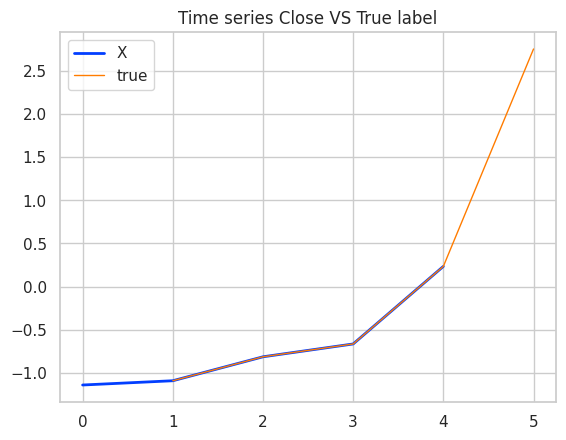

In [292]:
config = {
  'batch_size': 32,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [293]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )
        # self.linear_scale = nn.Linear(2,1)
        # self.linear_out = nn.Linear(context_len*d_model, output_dim)

    def forward(self, x):
        return self.model(x) #+ x[:,:,0:1]
        # return self.linear_out(self.model(x).flatten(1)).unsqueeze(1) #+ x[:,:,0:1]
        # return self.linear_scale(torch.cat([self.model(x) , x[:,:,0:1]],dim=-1))


In [304]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([0.2738, 0.2739, 0.4985, 0.6103, 0.6206], device='cuda:0') tensor([0.2739, 0.4985, 0.6103, 0.6206, 0.5903], device='cuda:0')
x shape: torch.Size([32, 5, 774]) y shape: torch.Size([32, 5])
out shape: torch.Size([32, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [32, 5, 512]  2.637824M  2.633728M
1_model.0.Dropout_dp            -  [32, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [32, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [32, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [32, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [32, 5, 512]          -          -
6_model.Dropout_4               -  [32, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [32, 5, 1]      513.0      512.0
---------------------------------------------------------------------
 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [305]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [306]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [307]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8695	 Learning Rate 0.0020000	 Validation Loss 0.2098

Epoch: 2/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5477	 Learning Rate 0.0016000	 Validation Loss 0.1291

Epoch: 3/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3901	 Learning Rate 0.0012800	 Validation Loss 0.1132

Epoch: 4/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2539	 Learning Rate 0.0010240	 Validation Loss 0.0764

Epoch: 5/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1447	 Learning Rate 0.0008192	 Validation Loss 0.1603

Epoch: 6/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1422	 Learning Rate 0.0006554	 Validation Loss 0.0747

Epoch: 7/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1461	 Learning Rate 0.0005243	 Validation Loss 0.0754

Epoch: 8/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1026	 Learning Rate 0.0004194	 Validation Loss 0.0935

Epoch: 9/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0851	 Learning Rate 0.0003355	 Validation Loss 0.1329

Epoch: 10/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1173	 Learning Rate 0.0002684	 Validation Loss 0.1275

Epoch: 11/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0659	 Learning Rate 0.0002147	 Validation Loss 0.0879

Epoch: 12/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0772	 Learning Rate 0.0001718	 Validation Loss 0.0710

Epoch: 13/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0592	 Learning Rate 0.0001374	 Validation Loss 0.0681

Epoch: 14/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0736	 Learning Rate 0.0001100	 Validation Loss 0.0686

Epoch: 15/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0830	 Learning Rate 0.0000880	 Validation Loss 0.0709

Epoch: 16/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0691	 Learning Rate 0.0000704	 Validation Loss 0.0733

Epoch: 17/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0667	 Learning Rate 0.0000563	 Validation Loss 0.0754

Epoch: 18/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0717	 Learning Rate 0.0000450	 Validation Loss 0.0775

Epoch: 19/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0737	 Learning Rate 0.0000360	 Validation Loss 0.0797

Epoch: 20/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0436	 Learning Rate 0.0000288	 Validation Loss 0.0806

Epoch: 21/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0686	 Learning Rate 0.0000231	 Validation Loss 0.0812

Epoch: 22/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0543	 Learning Rate 0.0000184	 Validation Loss 0.0827

Epoch: 23/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0745	 Learning Rate 0.0000148	 Validation Loss 0.0837

Epoch: 24/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0585	 Learning Rate 0.0000118	 Validation Loss 0.0847

Epoch: 25/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0732	 Learning Rate 0.0000094	 Validation Loss 0.0849

Epoch: 26/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0716	 Learning Rate 0.0000076	 Validation Loss 0.0847

Epoch: 27/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0632	 Learning Rate 0.0000060	 Validation Loss 0.0846

Epoch: 28/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0474	 Learning Rate 0.0000048	 Validation Loss 0.0843

Epoch: 29/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0654	 Learning Rate 0.0000039	 Validation Loss 0.0838

Epoch: 30/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0413	 Learning Rate 0.0000031	 Validation Loss 0.0835

Epoch: 31/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0534	 Learning Rate 0.0000025	 Validation Loss 0.0832

Epoch: 32/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0577	 Learning Rate 0.0000020	 Validation Loss 0.0830

Epoch: 33/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0308	 Learning Rate 0.0000016	 Validation Loss 0.0828

Epoch: 34/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0556	 Learning Rate 0.0000013	 Validation Loss 0.0826

Epoch: 35/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0663	 Learning Rate 0.0000010	 Validation Loss 0.0825

Epoch: 36/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0589	 Learning Rate 0.0000008	 Validation Loss 0.0824

Epoch: 37/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0822	 Learning Rate 0.0000006	 Validation Loss 0.0824

Epoch: 38/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0388	 Learning Rate 0.0000005	 Validation Loss 0.0823

Epoch: 39/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0701	 Learning Rate 0.0000004	 Validation Loss 0.0823

Epoch: 40/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0689	 Learning Rate 0.0000003	 Validation Loss 0.0823

Epoch: 41/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0536	 Learning Rate 0.0000003	 Validation Loss 0.0822

Epoch: 42/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0645	 Learning Rate 0.0000002	 Validation Loss 0.0822

Epoch: 43/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0581	 Learning Rate 0.0000002	 Validation Loss 0.0822

Epoch: 44/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0628	 Learning Rate 0.0000001	 Validation Loss 0.0822

Epoch: 45/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0583	 Learning Rate 0.0000001	 Validation Loss 0.0822

Epoch: 46/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0600	 Learning Rate 0.0000001	 Validation Loss 0.0822

Epoch: 47/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0604	 Learning Rate 0.0000001	 Validation Loss 0.0822

Epoch: 48/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0397	 Learning Rate 0.0000001	 Validation Loss 0.0822

Epoch: 49/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0668	 Learning Rate 0.0000000	 Validation Loss 0.0822

Epoch: 50/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0721	 Learning Rate 0.0000000	 Validation Loss 0.0822


Text(0.5, 1.0, 'Validation loss')

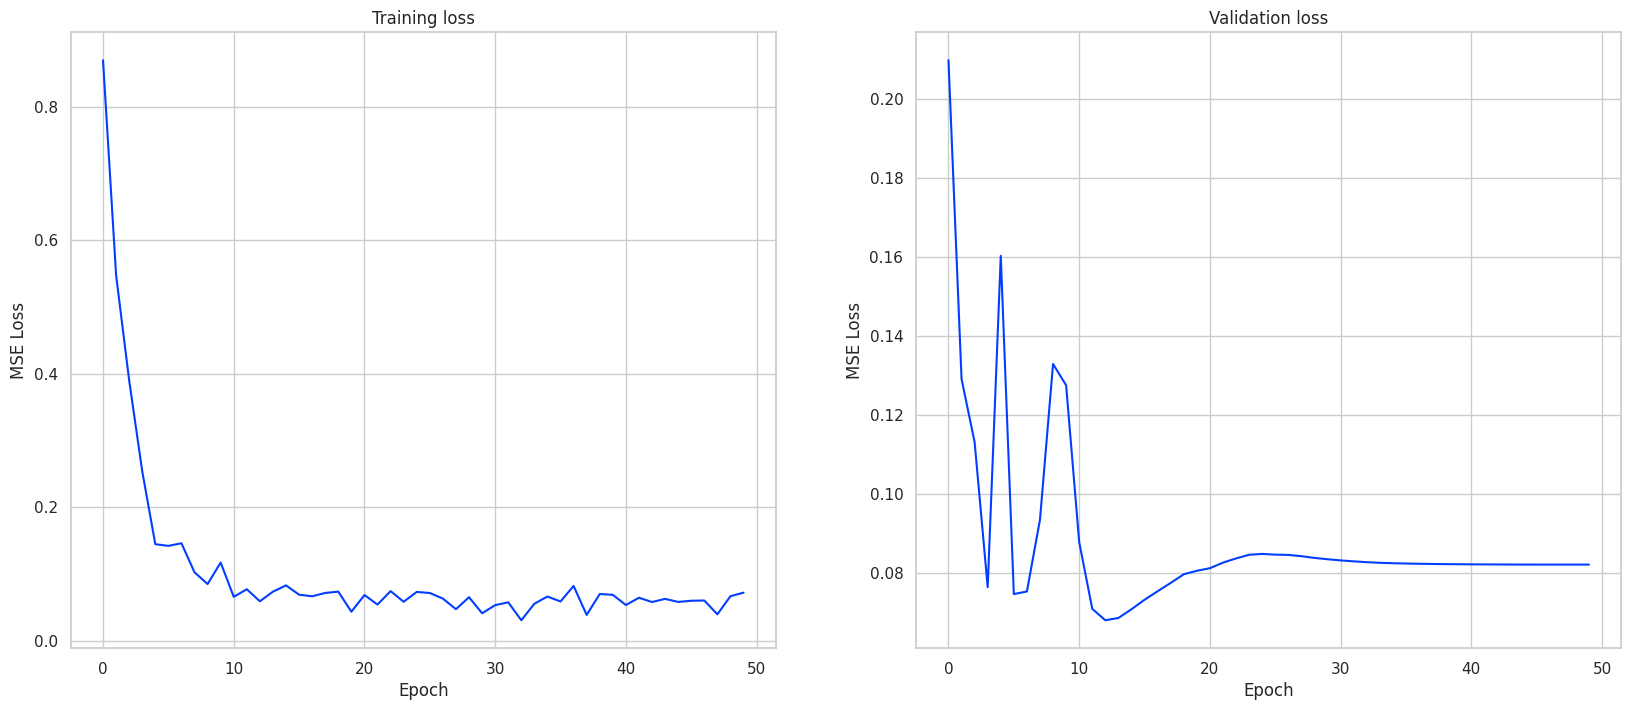

In [308]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [309]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
prediction.shape, true_labels.shape
bert_embeddings_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  62.021545  7.875376  5.319493  0.126039     0.434927            0.20091   

   Spearman Corr(IC)  
0           0.207638

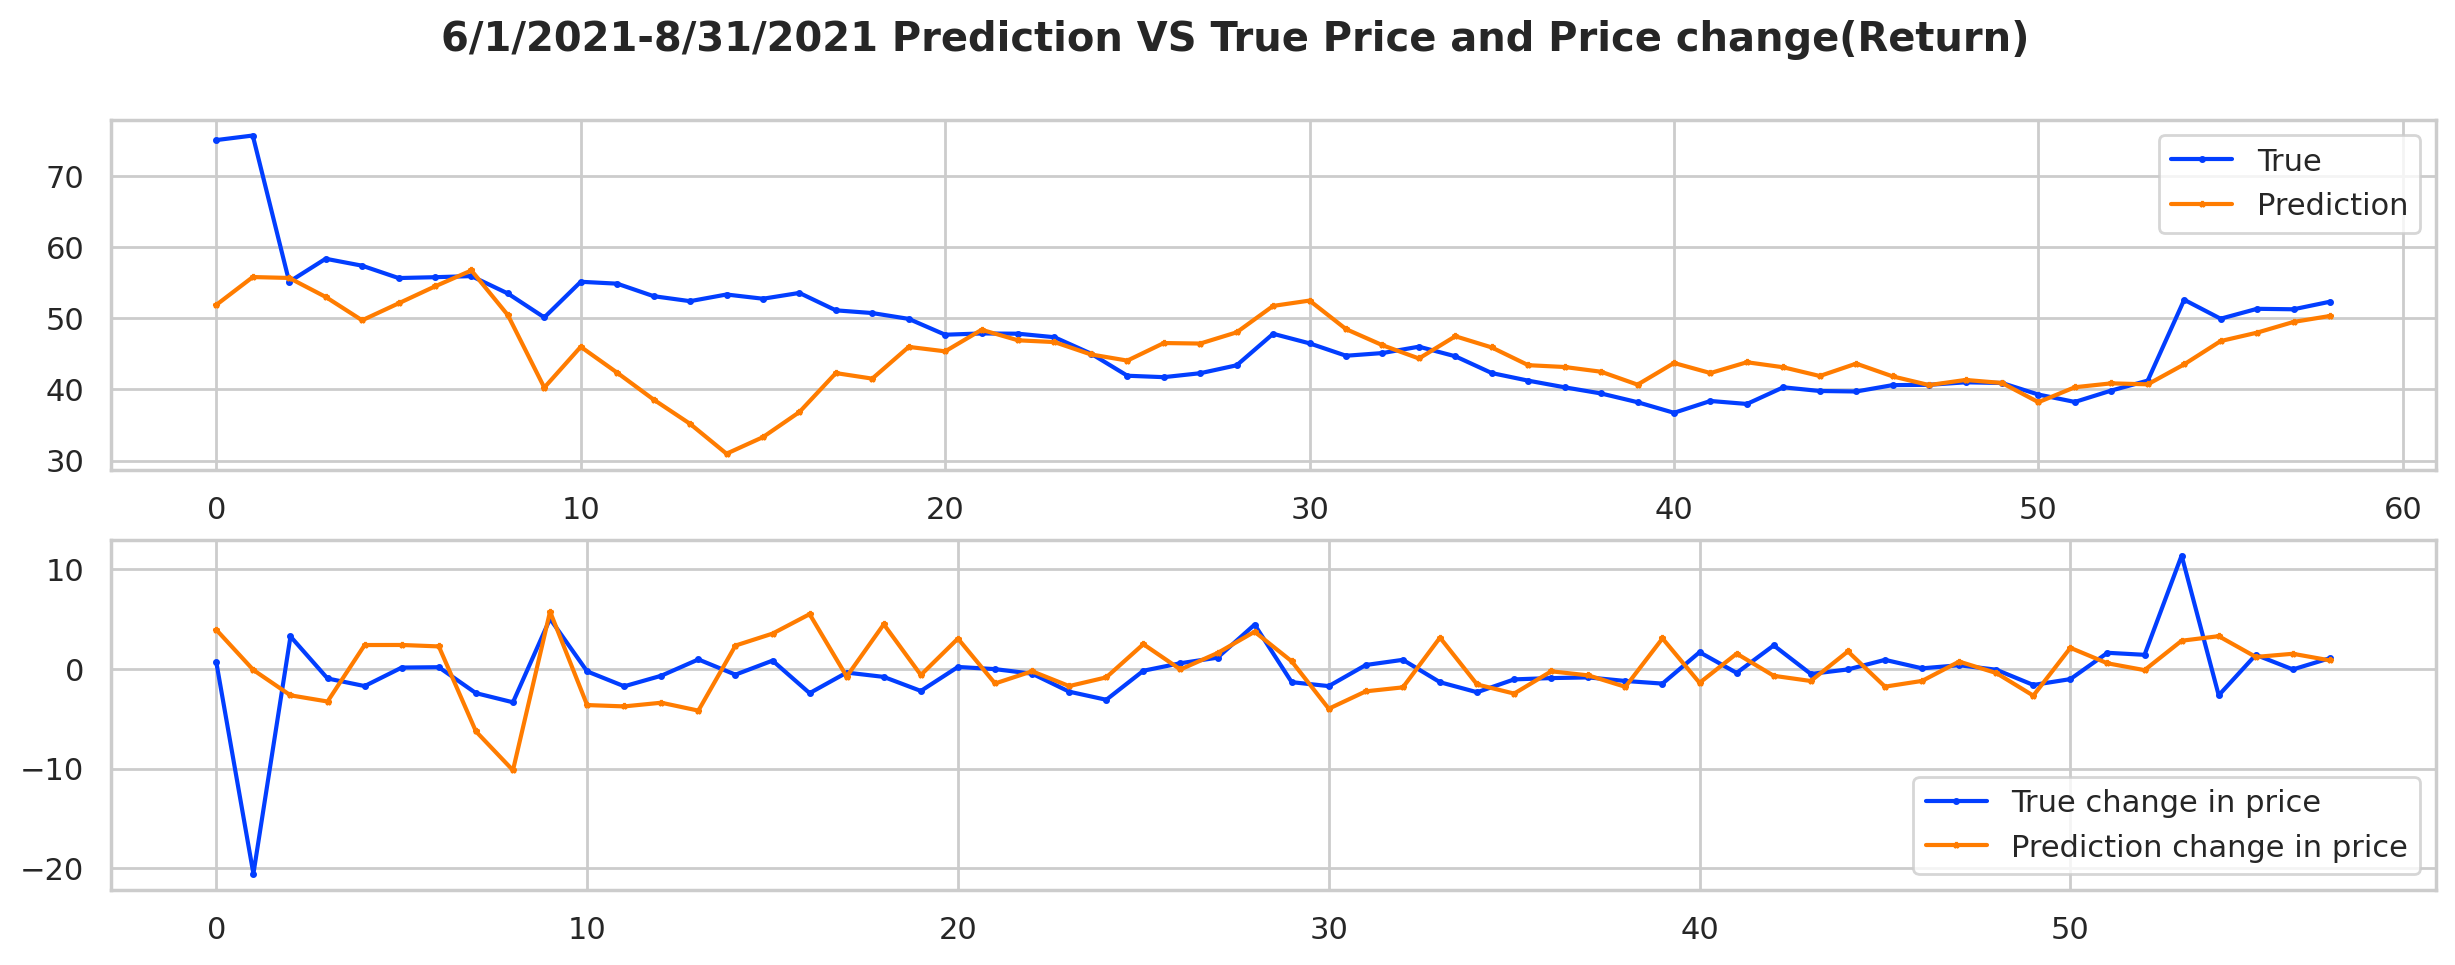

In [310]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)

ax[0].plot(true_labels, label='True', marker='.', markersize=3)
ax[0].plot(prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [314]:
df_inferencing = df_ts[df_ts.index<pd.to_datetime('2021-09-01')]
inference_indices = get_windows(df_inferencing, window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_inferencing.values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [315]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
# print("Serial Correlation, True Correlation(IC)")
# print(np.corrcoef(prediction,true_labels)[0,1], np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1])
bert_embeddings_train_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  45.753624  6.764143  4.249728  0.106177     0.912006           0.688969   

   Spearman Corr(IC)  
0           0.366657

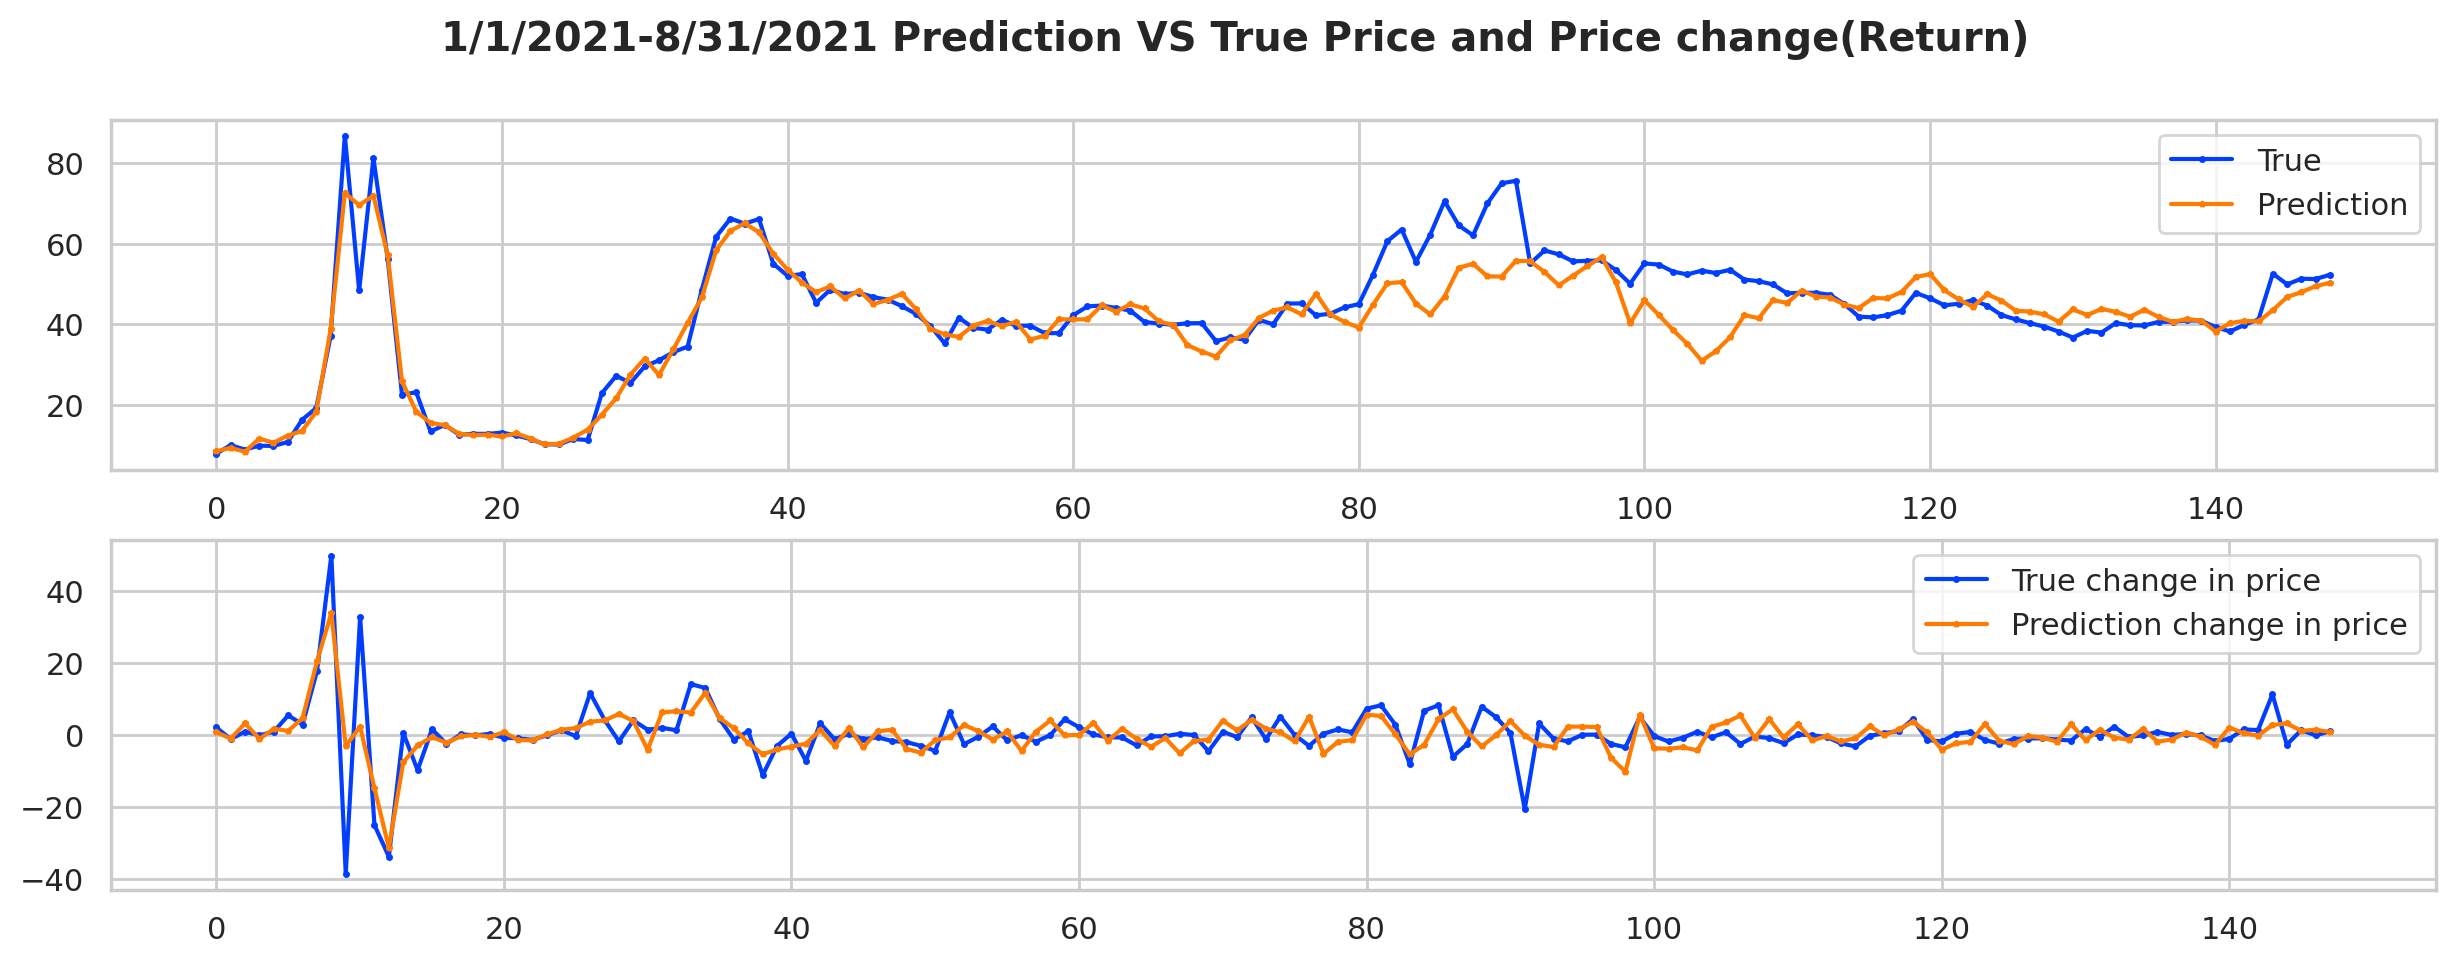

In [316]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)

ax[0].plot(true_labels, label='True', marker='.', markersize=3)
ax[0].plot(prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Metrics**

In [337]:
df_metrics = pd.concat([baseline_test_metrics, tfidf_test_metrics, bert_embeddings_test_metrics])
df_metrics.index = ['Baseline', 'TF-IDF', 'Bert_embeddings']
df_metrics

MSE       RMSE        MAE      MAPE  Serial Corr  \
Baseline          61.365913   7.833640   5.555622  0.125522     0.869164   
TF-IDF           204.023376  14.283675  12.749937  0.365236     0.621220   
Bert_embeddings   62.021545   7.875376   5.319493  0.126039     0.434927   

                 Pearson Corr(IC),  Spearman Corr(IC)  
Baseline                 -0.202205          -0.096867  
TF-IDF                   -0.045079           0.033622  
Bert_embeddings           0.200910           0.207638